# 0. Imports and Useful Functions from Other Notebooks

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
sns.set()
df = pd.read_pickle('male_test.pkl')
# dft = pd.read_pickle('male_train.pkl')
import os
import pickle
from glob import glob
from scipy.stats import pearsonr
from scipy.stats import gaussian_kde
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error

In [2]:
def scatter_plot_heatmap(x, y, xlabel, ylabel, title, equality_line=True, set_scale=False):
    
    if isinstance(x, pd.Series):
        x = x.to_numpy()
    
    if isinstance(y, pd.Series):
        y = y.to_numpy()
    
    fig = plt.figure(figsize=[7.2, 7.2])
    sns.set_style("darkgrid", {'image.cmap': u'plasma'})
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    plt.scatter(x,y,c=z,s=50)
    if equality_line == True:
        plt.plot(x, x, ls="-", color = sns.xkcd_rgb['black'], label='Equality Line') #this is just the line of equality
    
    X_mat=np.vstack((np.ones(len(x)), x)).T
    beta_hat = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(y)
    b,w = beta_hat[0],beta_hat[1]
    x2 = np.linspace(np.min(x),np.max(x),num=10)
    y2 = w * x2 + b
    plt.plot(x2,y2,ls='--', color= sns.xkcd_rgb['red'], label='Linear Regression Line')
    
    pearson_correlation = pearsonr(x,y)[0]
    
    if set_scale == True:
        x_min, x_max = np.min(x), np.max(x)
        y_min, y_max = np.min(y), np.max(y)
        c_min, c_max = min(x_min, y_min), max(x_max, y_max)
        plt.xlim([c_min-2, c_max+2])
        plt.ylim([c_min-2, c_max+2])
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    lbl = 'Pearson R = '+str(round(pearson_correlation,3))
    plt.plot([],[],' ',label=lbl)
    
    plt.title(title)
    plt.legend()
    plt.show()
    
def kde_plot(x, y, xlabel, ylabel, title):
    plt.figure()
    sns.kdeplot(x, label='Ground Truth')
    sns.kdeplot(y, label= ylabel)
    plt.legend()
    plt.title(title)
    
def age_deconfounding(predicted_ages, chronological_ages):
    
    if isinstance(predicted_ages, pd.Series):
        predicted_ages = predicted_ages.to_numpy()
    
    if isinstance(chronological_ages, pd.Series):
        chronological_ages = chronological_ages.to_numpy()
    
    ones = np.ones(len(chronological_ages))
    chronological_ages_squared = np.square(chronological_ages)
    chronological_ages_confounds = np.array([ones, chronological_ages])
    
    ones_predicted = np.ones(len(predicted_ages))
    predicted_ages_squared = np.square(predicted_ages)
    predicted_ages_confounds = np.array([ones_predicted, predicted_ages])
    
    predicted_ages = np.reshape(predicted_ages, (len(predicted_ages), 1) )
    beta = np.dot( np.linalg.pinv(chronological_ages_confounds.T), predicted_ages )

    corrected_predicted_ages = (predicted_ages.flatten() - beta[0])/beta[1]
    
    return corrected_predicted_ages

# 1. Fitting All Variables

In [3]:
# dft.iloc[0].dataframe.head()

In [4]:
# df_train = {}
# for idx in range(len(df)):
#     name = dft.iloc[idx].modality
#     data = dft.iloc[idx].dataframe.mean_output_age.to_list()
#     df_train[name] = data
    
# df_train = pd.DataFrame.from_dict(df_train)
# df_train['target_age'] = dft.iloc[0].dataframe.target_age.to_list()

In [5]:
# df_train.head()

In [6]:
# df.iloc[0].dataframe.head()

In [7]:
df_test = {}
df_test['Unnamed: 0'] = df.iloc[0].dataframe['Unnamed: 0'].to_list()
for idx in range(len(df)):
    name = df.iloc[idx].modality
    data = df.iloc[idx].dataframe.mean_output_age.to_list()
    df_test[name] = data
    
df_test = pd.DataFrame.from_dict(df_test)
df_test['target_age'] = df.iloc[0].dataframe.target_age.to_list()

In [8]:
df_testA, df_testB = train_test_split(df_test, test_size=0.5, random_state=1)
subjects_testA = df_testA['Unnamed: 0'].to_list()
subjects_testB = df_testB['Unnamed: 0'].to_list()
df_testA = df_testA.drop(labels='Unnamed: 0', axis=1)
df_testB = df_testB.drop(labels='Unnamed: 0', axis=1)

df_train = df_testA
df_test = df_testB

In [9]:
df_testA

,T1_nonlinear,T1_linear,jacobian,vbm,T2_nonlinear,T2_lesions,swi,rsfmri_0,rsfmri_1,rsfmri_2,...,tbss_FA,tbss_ICVF,tbss_ISOVF,tbss_L1,tbss_L2,tbss_L3,tbss_MD,tbss_MO,tbss_OD,target_age
1588,71.148967,68.758153,61.669696,64.744407,68.486633,71.360700,61.890867,65.599383,65.690795,62.132266,...,67.909127,64.590390,69.591637,67.349990,66.998962,67.754927,67.844347,69.083805,65.371872,69.037100
935,72.722655,74.274728,73.627597,76.721025,72.708425,71.743233,77.293670,70.248365,72.634313,69.213218,...,72.908250,75.025737,73.012710,70.210583,70.535967,70.304587,69.676443,68.894653,71.443407,73.034836
1450,53.217894,54.670809,59.846333,52.477524,53.091773,59.118936,59.535689,66.382952,64.171692,65.664289,...,54.274742,55.345449,50.212408,52.080364,51.377991,51.042342,51.875048,57.676217,56.809871,56.950137
2512,74.175563,72.697128,74.099559,74.274790,76.285502,68.507303,74.087580,73.800220,74.171987,72.693825,...,74.826955,74.367054,71.739193,73.452775,72.792558,72.229397,73.131657,74.697147,73.385949,74.185731
1353,51.269549,54.316068,55.047965,52.875921,52.832307,53.800731,54.469474,58.777314,56.815188,57.829699,...,52.358435,51.214033,54.785422,54.488783,54.894757,55.669731,54.966000,51.753970,52.647824,46.675546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2895,68.766762,71.101570,70.367163,65.406616,69.015688,65.642769,64.954569,61.288846,64.017198,60.159990,...,71.324177,71.450927,70.124225,68.738298,69.041345,69.600773,68.669713,65.290835,68.079060,72.299863
2763,62.977201,63.566440,61.328991,62.450789,62.443869,61.490969,67.437797,60.017762,58.644575,63.557648,...,60.387687,60.071782,62.241811,64.079780,64.293267,64.175193,61.909395,64.599708,65.660425,66.124087
905,70.890430,67.332623,72.631668,66.376517,69.516073,71.266423,73.919892,70.141248,70.650945,71.114835,...,65.015291,68.461108,69.951328,73.274285,71.721979,68.954783,71.726060,70.784825,69.117790,74.020205
3980,65.784067,66.013202,68.745940,65.850317,67.242687,63.450094,67.237207,67.940033,66.493972,61.675599,...,67.027719,68.024317,66.486773,67.338935,67.296982,65.385612,65.496723,70.243285,68.312545,69.108607


In [10]:
subjects_testA

[24355392,
 22250756,
 25627859,
 24298305,
 25895569,
 22028150,
 24014646,
 22619264,
 21603706,
 24694456,
 25594242,
 22607753,
 25948171,
 21021826,
 25064170,
 22858259,
 25811016,
 23379975,
 23542060,
 22370657,
 22363477,
 24987381,
 21700151,
 24304257,
 25515115,
 25635481,
 25722851,
 25327834,
 24511689,
 23304758,
 21466429,
 25188102,
 21605008,
 25228094,
 22303812,
 22181303,
 21291653,
 24527970,
 21219990,
 23170163,
 22801991,
 21560384,
 24918338,
 22912625,
 21534952,
 21491825,
 21144187,
 22778796,
 23050285,
 25977392,
 21872159,
 21189849,
 24038499,
 25038114,
 23478086,
 22868601,
 23636064,
 24792946,
 23584316,
 24568931,
 25752700,
 22662770,
 23912465,
 23658050,
 24126560,
 21977122,
 25620312,
 23690012,
 22006106,
 22906404,
 25940871,
 21479414,
 25023189,
 25888912,
 25770252,
 24118660,
 24413168,
 23381470,
 23778048,
 24386767,
 25391734,
 26000292,
 23471844,
 24884889,
 21586856,
 22060576,
 21567013,
 22749140,
 21278390,
 25095724,
 22902510,

In [11]:
df.iloc[0].dataframe.iloc[[2820]]

,Unnamed: 0,target_age,output_age_1,age_delta_1,loss_1,output_age_2,age_delta_2,loss_2,output_age_3,age_delta_3,loss_3,mean_output_age,mean_age_delta,output_age_decon,age_delta_decon
2820,21917588,63.484817,67.869774,4.384957,19.227844,67.180405,3.695587,13.657366,64.86486,1.380043,1.904519,66.638346,3.153529,67.148212,3.663395


In [12]:
df

,modality,dataframe
0,T1_nonlinear,Unnamed: 0 target_age output_age_1 ag...
1,T1_linear,Unnamed: 0 target_age output_age_1 ag...
2,jacobian,Unnamed: 0 target_age output_age_1 ag...
3,vbm,Unnamed: 0 target_age output_age_1 ag...
4,T2_nonlinear,Unnamed: 0 target_age output_age_1 ag...
5,T2_lesions,Unnamed: 0 target_age output_age_1 ag...
6,swi,Unnamed: 0 target_age output_age_1 ag...
7,rsfmri_0,Unnamed: 0 target_age output_age_1 ag...
8,rsfmri_1,Unnamed: 0 target_age output_age_1 ag...
9,rsfmri_2,Unnamed: 0 target_age output_age_1 ag...


In [13]:
modalitiesA, modalitiesB = [], []
dataframesA, dataframesB = [], []
for idx in range(len(df)):
    modalitiesA.append(df.iloc[idx].modality)
    modalitiesB.append(df.iloc[idx].modality)
    dataframe = df.iloc[idx].dataframe
    dfA, dfB = train_test_split(dataframe, test_size=0.5, random_state=1)
    dataframesA.append(dfA)
    dataframesB.append(dfB)
dfA = pd.DataFrame.from_dict({
    'modality': modalitiesA,
    'dataframe': dataframesA
})
dfB = pd.DataFrame.from_dict({
    'modality': modalitiesB,
    'dataframe': dataframesB
})
dfA.to_pickle('male_testA.pkl', protocol = 4)
dfB.to_pickle('male_testB.pkl', protocol = 4)

In [14]:
subjects_testA = np.array(subjects_testA).astype(int)
subjects_testB = np.array(subjects_testB).astype(int)
np.savetxt('male_testA.txt', subjects_testA, fmt='%s')
np.savetxt('male_testB.txt', subjects_testB, fmt='%s')

In [15]:
dfA = pd.read_pickle('male_testA.pkl')
dfA.iloc[0].dataframe

,Unnamed: 0,target_age,output_age_1,age_delta_1,loss_1,output_age_2,age_delta_2,loss_2,output_age_3,age_delta_3,loss_3,mean_output_age,mean_age_delta,output_age_decon,age_delta_decon
1588,24355392,69.037100,68.824900,-0.212203,0.045030,73.037220,4.000116,16.000926,71.584780,2.547677,6.490660,71.148967,2.111866,72.635546,3.598446
935,22250756,73.034836,72.894130,-0.140709,0.019799,74.609880,1.575042,2.480759,70.663956,-2.370880,5.621074,72.722655,-0.312181,74.549996,1.515160
1450,25627859,56.950137,55.483955,-1.466181,2.149687,53.189133,-3.761004,14.145150,50.980595,-5.969542,35.635431,53.217894,-3.732242,50.821743,-6.128394
2512,24298305,74.185731,73.598850,-0.586884,0.344433,74.392960,0.207229,0.042944,74.534880,0.349151,0.121906,74.175563,-0.010167,76.317512,2.131781
1353,25895569,46.675546,50.000480,3.324934,11.055187,51.833390,5.157843,26.603343,51.974777,5.299231,28.081847,51.269549,4.594003,48.451510,1.775963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2895,24916244,72.299863,70.090220,-2.209646,4.882535,67.505780,-4.794080,22.983206,68.704285,-3.595579,12.928186,68.766762,-3.533102,69.737507,-2.562356
2763,21297884,66.124087,61.734116,-4.389971,19.271847,64.035080,-2.089007,4.363949,63.162407,-2.961680,8.771547,62.977201,-3.146886,62.694295,-3.429791
905,25401713,74.020205,68.811390,-5.208812,27.131720,73.037220,-0.982989,0.966268,70.822680,-3.197528,10.224184,70.890430,-3.129775,72.321027,-1.699178
3980,25888324,69.108607,63.974922,-5.133684,26.354715,66.746570,-2.362040,5.579232,66.630710,-2.477900,6.139987,65.784067,-3.324539,66.108951,-2.999656


In [16]:
def LinearRegression_wrap(df_train, df_test, modalities = None, number_of_modalities=None, 
                          show_plots=False, verbose=False, deconfound=False):
    
    Xtrain = []
    Ytrain = []
    
    if modalities == None:
        if number_of_modalities == None:
            for col in df_train.columns[:-1]:
                Xtrain.append(np.array(df_train[col].to_list()))
        else:
            for col in df_train.columns[:number_of_modalities]:
                print(col)
                Xtrain.append(np.array(df_train[col].to_list()))
    else:
        for modality in modalities:
            Xtrain.append(np.array(df_train[modality].to_list()))

    Xtrain = np.array(Xtrain)
    Ytrain = np.array(df_train['target_age'].to_list())

    reg = LinearRegression().fit(Xtrain.T, Ytrain)
    coefficients = reg.coef_
    intercept = reg.intercept_

    Xtest = []
    
    if modalities == None:
        if number_of_modalities == None:
            for col in df_train.columns[:-1]:
                Xtest.append(np.array(df_test[col].to_list()))
        else:
            for col in df_train.columns[:number_of_modalities]:
                Xtest.append(np.array(df_test[col].to_list()))
    else:
        for modality in modalities:
            Xtest.append(np.array(df_test[modality].to_list()))
        
    Xtest = np.array(Xtest)
    Ytest = np.array(df_test['target_age'].to_list())

    Yhat = reg.predict(Xtest.T)
    Age_Deltas = Yhat - Ytest
    
#     print(mean_squared_error(Yhat, Ytest, squared=False))
    
    if deconfound == True:
        Yhat_decon = age_deconfounding(Yhat, Ytest)
        Age_Deltas_decon = Yhat_decon - Ytest
    else:
        Yhat_decon = None
        Age_Deltas_decon = None
    
    mae = np.abs(Age_Deltas).mean()
    pr = pearsonr(Ytest, Yhat)[0]
    
    if deconfound == True:
        mae_decon = np.abs(Age_Deltas_decon).mean()
        pr_decon = pearsonr(Ytest, Yhat_decon)[0]
    else:
        mae_decon = None
        pr_decon = None
    
    if verbose == True:
        print('MAE=', mae)
        print('PR=', pr)
        if deconfound == True:
            print('MAE Decon=', mae_decon)
            print('PR Decon=', pr_decon)
    
    if show_plots == True:
        scatter_plot_heatmap(x=Ytest, y=Yhat, xlabel='Ground Truth', 
                               ylabel='Predicted Age', title=None, set_scale=True)

        scatter_plot_heatmap(x=Ytest, y=Age_Deltas, xlabel='Ground Truth', 
                               ylabel='Predicted Age Delta', title=None, set_scale=False, 
                               equality_line=False)

        kde_plot(x=Ytest, y=Yhat, xlabel='Ground Truth', ylabel='Predicted Age', title=None)
        
        if deconfound == True:
            scatter_plot_heatmap(x=Ytest, y=Yhat_decon, xlabel='Ground Truth', 
                                   ylabel='Predicted Age Deconfounded', title=None, set_scale=True)

            scatter_plot_heatmap(x=Ytest, y=Age_Deltas_decon, xlabel='Ground Truth', 
                                   ylabel='Predicted Age Delta Deconfounded', title=None, set_scale=False, 
                                   equality_line=False)

            kde_plot(x=Ytest, y=Yhat_decon, xlabel='Ground Truth', ylabel='Predicted Age Deconfounded', title=None)            
    
    if deconfound == True:
        return (reg, coefficients, intercept, mae_decon, pr_decon, Xtrain, Ytrain, Xtest, Ytest, Yhat_decon,
                Age_Deltas_decon, Yhat, Age_Deltas)
    else:
        return (reg, coefficients, intercept, mae, pr, Xtrain, Ytrain, Xtest, Ytest, Yhat, Age_Deltas)

In [17]:
def ElasticNet_wrap(df_train, df_test, modalities = None, number_of_modalities=None, 
                          show_plots=False, verbose=False, deconfound=False):
    
    Xtrain = []
    Ytrain = []
    
    if modalities == None:
        if number_of_modalities == None:
            for col in df_train.columns[:-1]:
                Xtrain.append(np.array(df_train[col].to_list()))
        else:
            for col in df_train.columns[:number_of_modalities]:
                print(col)
                Xtrain.append(np.array(df_train[col].to_list()))
    else:
        for modality in modalities:
            Xtrain.append(np.array(df_train[modality].to_list()))

    Xtrain = np.array(Xtrain)
    Ytrain = np.array(df_train['target_age'].to_list())

    model = ElasticNet(alpha=0.1, l1_ratio=0.5)       
    reg = model.fit(Xtrain.T, Ytrain)
#     reg = LinearRegression().fit(Xtrain.T, Ytrain)
    coefficients = reg.coef_
    intercept = reg.intercept_

    Xtest = []
    
    if modalities == None:
        if number_of_modalities == None:
            for col in df_train.columns[:-1]:
                Xtest.append(np.array(df_test[col].to_list()))
        else:
            for col in df_train.columns[:number_of_modalities]:
                Xtest.append(np.array(df_test[col].to_list()))
    else:
        for modality in modalities:
            Xtest.append(np.array(df_test[modality].to_list()))
        
    Xtest = np.array(Xtest)
    Ytest = np.array(df_test['target_age'].to_list())

    Yhat = reg.predict(Xtest.T)
    Age_Deltas = Yhat - Ytest
    
    if deconfound == True:
        Yhat_decon = age_deconfounding(Yhat, Ytest)
        Age_Deltas_decon = Yhat_decon - Ytest
    else:
        Yhat_decon = None
        Age_Deltas_decon = None
    
    mae = np.abs(Age_Deltas).mean()
    pr = pearsonr(Ytest, Yhat)[0]
    
    if deconfound == True:
        mae_decon = np.abs(Age_Deltas_decon).mean()
        pr_decon = pearsonr(Ytest, Yhat_decon)[0]
    else:
        mae_decon = None
        pr_decon = None
    
    if verbose == True:
        print('MAE=', mae)
        print('PR=', pr)
        if deconfound == True:
            print('MAE Decon=', mae_decon)
            print('PR Decon=', pr_decon)
    
    if show_plots == True:
        scatter_plot_heatmap(x=Ytest, y=Yhat, xlabel='Ground Truth', 
                               ylabel='Predicted Age', title=None, set_scale=True)

        scatter_plot_heatmap(x=Ytest, y=Age_Deltas, xlabel='Ground Truth', 
                               ylabel='Predicted Age Delta', title=None, set_scale=False, 
                               equality_line=False)

        kde_plot(x=Ytest, y=Yhat, xlabel='Ground Truth', ylabel='Predicted Age', title=None)
        
        if deconfound == True:
            scatter_plot_heatmap(x=Ytest, y=Yhat_decon, xlabel='Ground Truth', 
                                   ylabel='Predicted Age Deconfounded', title=None, set_scale=True)

            scatter_plot_heatmap(x=Ytest, y=Age_Deltas_decon, xlabel='Ground Truth', 
                                   ylabel='Predicted Age Delta Deconfounded', title=None, set_scale=False, 
                                   equality_line=False)

            kde_plot(x=Ytest, y=Yhat_decon, xlabel='Ground Truth', ylabel='Predicted Age Deconfounded', title=None)            
    
    if deconfound == True:
        return (reg, coefficients, intercept, mae_decon, pr_decon, Xtrain, Ytrain, Xtest, Ytest, Yhat_decon,
                Age_Deltas_decon)
    else:
        return (reg, coefficients, intercept, mae, pr, Xtrain, Ytrain, Xtest, Ytest, Yhat, Age_Deltas)

Modality      : MAE             |  MAE (Decon)       

T1_nonlinear  :  2.227 ± 0.024  |   2.429 ± 0.025 

T1_linear     :  2.332 ± 0.025  |   2.550 ± 0.027 

T2_nonlinear  :  2.204 ± 0.024  |   2.372 ± 0.026 


In [18]:
# Xtrain = []
# Ytrain = []
# for col in df_train.columns[:-1]:
#     Xtrain.append(np.array(df_train[col].to_list()))
# Xtrain = np.array(Xtrain)
# Ytrain = np.array(df_train['target_age'].to_list())

# reg = LinearRegression().fit(Xtrain.T, Ytrain)
# coefficients = reg.coef_
# intercept = reg.intercept_

# Xtest = []
# for col in df_train.columns[:-1]:
#     Xtest.append(np.array(df_test[col].to_list()))
# Xtest = np.array(Xtest)
# Ytest = np.array(df_test['target_age'].to_list())
    
# Yhat = reg.predict(Xtest.T)

# # Yhat_decon = age_deconfounding(Yhat, Ytest)
# # Age_Deltas_decon = Yhat_decon - Ytest
# Yhat = age_deconfounding(Yhat, Ytest)

# Age_Deltas = Yhat - Ytest
# print('MAE=', np.abs(Age_Deltas).mean())
# print('PR=', pearsonr(Ytest, Yhat)[0])
# print(reg.intercept_)

# scatter_plot_heatmap(x=Ytest, y=Yhat, xlabel='Ground Truth', 
#                        ylabel='Predicted Age Deconfounded', title=None, set_scale=True)

# scatter_plot_heatmap(x=Ytest, y=Age_Deltas, xlabel='Ground Truth', 
#                        ylabel='Predicted Age Delta Deconfounded', title=None, set_scale=False, 
#                        equality_line=False)

# kde_plot(x=Ytest, y=Yhat, xlabel='Ground Truth', ylabel='Predicted Age Deconfounded', title=None)

MAE= 2.123892149147869
PR= 0.9343118013813391
MAE Decon= 2.272946466891486
PR Decon= 0.934311801381339


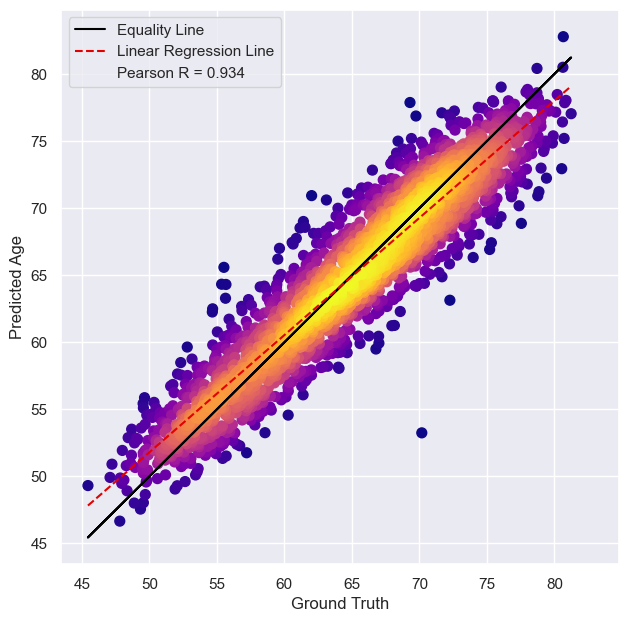

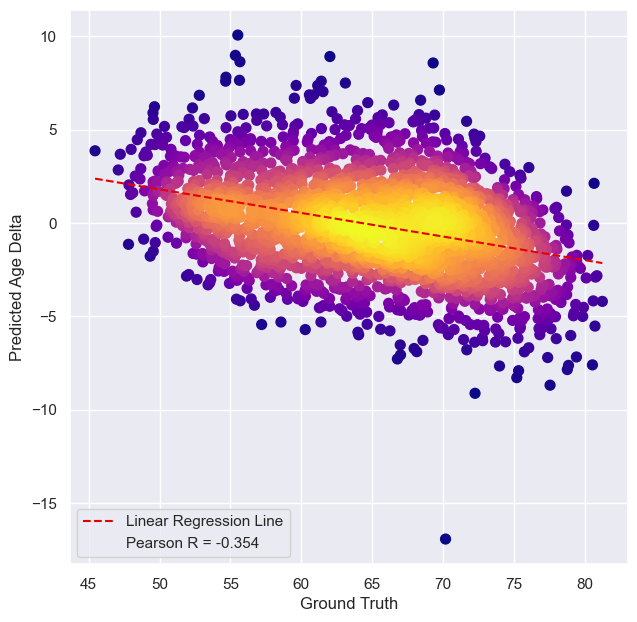

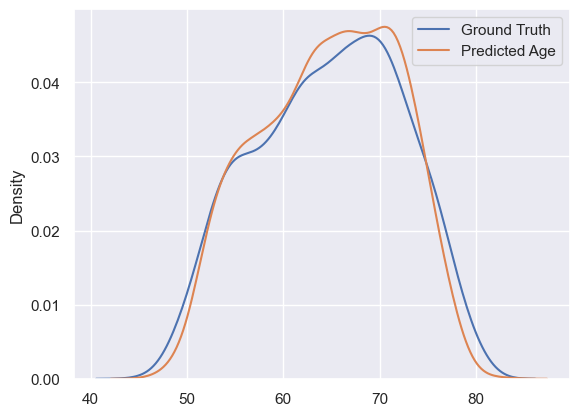

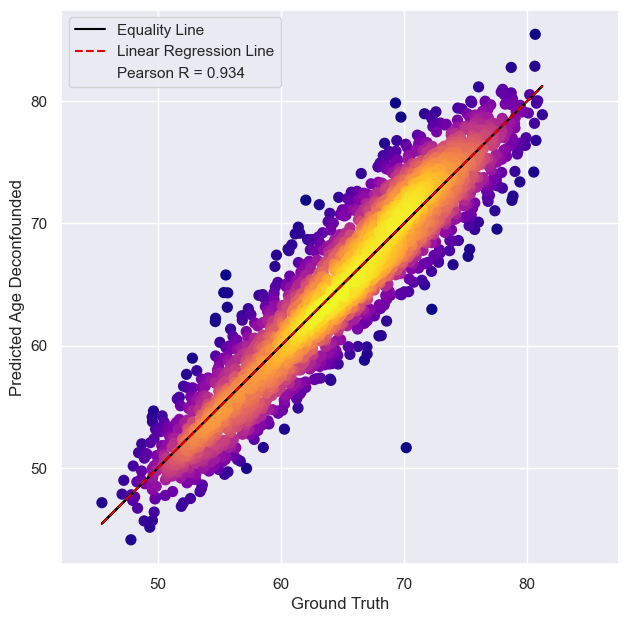

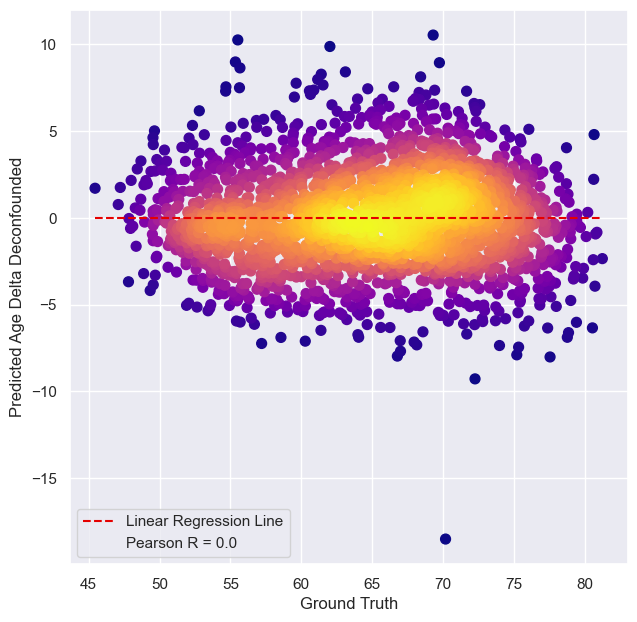

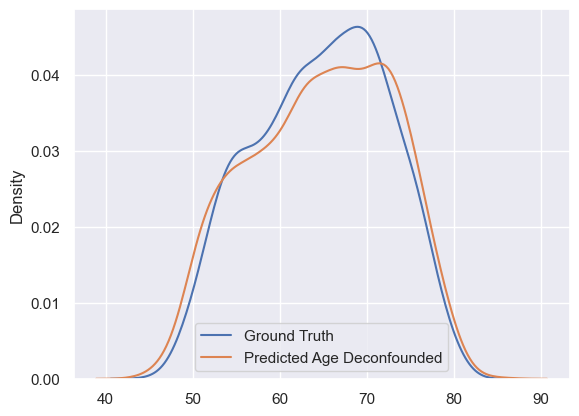

In [19]:
reg, coefficients, intercept, mae_decon, pr_decon, Xtrain, Ytrain, Xtest, Ytest, Yhat_decon, Age_Deltas_decon, Yhat, Age_Deltas = LinearRegression_wrap(
    df_train=df_testA, df_test=df_testB, number_of_modalities=None, show_plots=True, verbose=True, deconfound=True)

In [27]:
# YhatT = reg.predict(Xtrain.T)
# Age_Deltas_T = YhatT - Ytrain

# print('MAE Train=', np.abs(Age_Deltas_T).mean())
# print('PR Train=', pearsonr(Ytrain, YhatT)[0])

# scatter_plot_heatmap(x=Ytrain, y=YhatT, xlabel='Ground Truth', 
#                        ylabel='Predicted Age Deconfounded', title=None, set_scale=True)

# scatter_plot_heatmap(x=Ytrain, y=Age_Deltas_T, xlabel='Ground Truth', 
#                        ylabel='Predicted Age Delta Deconfounded', title=None, set_scale=False, 
#                        equality_line=False)

# kde_plot(x=Ytrain, y=YhatT, xlabel='Ground Truth', ylabel='Predicted Age Deconfounded', title=None)

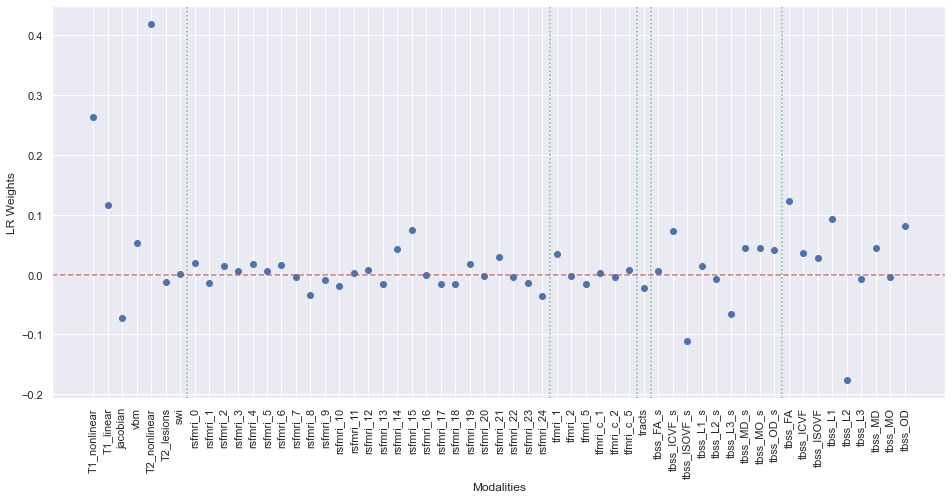

In [28]:
plt.figure(figsize=(16, 7.2))
# plt.plot(coefficients)
plt.scatter(np.arange(0, Xtrain.shape[0]), coefficients)
plt.xticks(np.arange(0, Xtrain.shape[0]), df.modality.to_list(), rotation=90);
plt.xlabel("Modalities")
plt.ylabel("LR Weights")
plt.axhline(y=0, color='r', linestyle='--', alpha=0.75);
plt.axvline(x=6.5, color='g', linestyle='dotted', alpha=0.75);
plt.axvline(x=31.5, color='g', linestyle='dotted', alpha=0.75);
plt.axvline(x=37.5, color='g', linestyle='dotted', alpha=0.75);
plt.axvline(x=38.5, color='g', linestyle='dotted', alpha=0.75);
plt.axvline(x=47.5, color='g', linestyle='dotted', alpha=0.75);

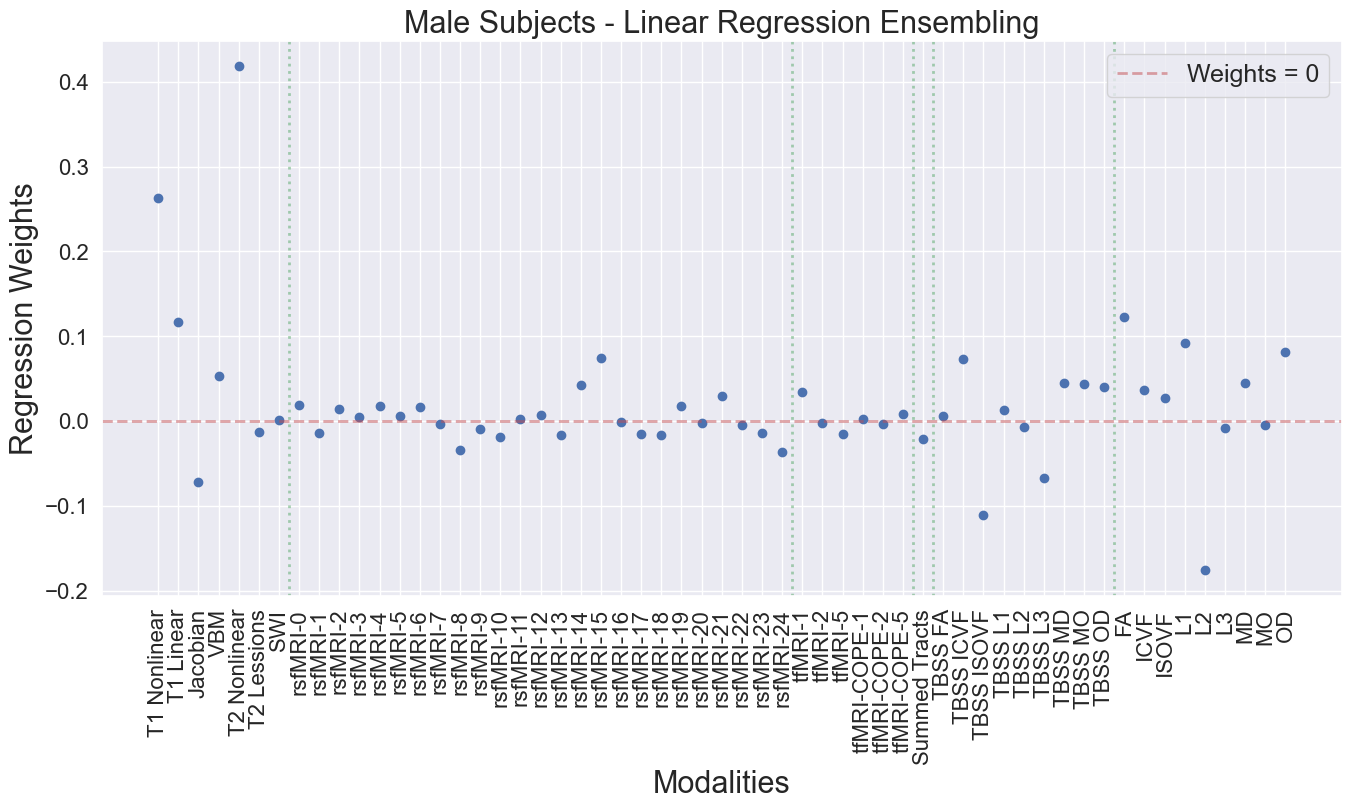

In [20]:
title_font_size=22
ticks_font_size=16
legend_font = 18
# figsize=(16, 9.6)

namesNN = [
    'T1 Nonlinear', 'T1 Linear', 'Jacobian', 'VBM', 'T2 Nonlinear', 'T2 Lessions', 'SWI', 'rsfMRI-0', 'rsfMRI-1',
    'rsfMRI-2', 'rsfMRI-3', 'rsfMRI-4', 'rsfMRI-5', 'rsfMRI-6', 'rsfMRI-7', 'rsfMRI-8', 'rsfMRI-9', 'rsfMRI-10', 
    'rsfMRI-11', 'rsfMRI-12', 'rsfMRI-13', 'rsfMRI-14', 'rsfMRI-15', 'rsfMRI-16', 'rsfMRI-17', 'rsfMRI-18', 'rsfMRI-19',
    'rsfMRI-20', 'rsfMRI-21', 'rsfMRI-22', 'rsfMRI-23', 'rsfMRI-24', 'tfMRI-1', 'tfMRI-2', 'tfMRI-5', 'tfMRI-COPE-1',
    'tfMRI-COPE-2', 'tfMRI-COPE-5', 'Summed Tracts', 'TBSS FA', 'TBSS ICVF', 'TBSS ISOVF', 'TBSS L1', 'TBSS L2',
    'TBSS L3', 'TBSS MD', 'TBSS MO', 'TBSS OD', 'FA', 'ICVF', 'ISOVF', 'L1', 'L2', 'L3', 'MD', 'MO', 'OD'
]

fig = plt.figure(figsize=(16, 7.2))

plt.scatter(np.arange(0, Xtrain.shape[0]), coefficients)
plt.xticks(np.arange(0, Xtrain.shape[0]), namesNN, rotation=90, fontsize= ticks_font_size);
plt.xlabel("Modalities", fontsize=title_font_size)
plt.yticks(fontsize=ticks_font_size)
plt.ylabel("Regression Weights", fontsize=title_font_size)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5, linewidth=2, label='Weights = 0');
plt.axvline(x=6.5, color='g', linestyle='dotted', alpha=0.5, linewidth=2);
plt.axvline(x=31.5, color='g', linestyle='dotted', alpha=0.5, linewidth=2);
plt.axvline(x=37.5, color='g', linestyle='dotted', alpha=0.5, linewidth=2);
plt.axvline(x=38.5, color='g', linestyle='dotted', alpha=0.5, linewidth=2);
plt.axvline(x=47.5, color='g', linestyle='dotted', alpha=0.5, linewidth=2);

plt.legend(loc=1, fontsize=legend_font)

plt.title('Male Subjects - Linear Regression Ensembling', fontsize=title_font_size)

fig.savefig('Male_linear_regression_weights.png', bbox_inches='tight')




In [19]:
df_output = pd.DataFrame.from_dict({
    'modality': 'LinearRegressionFull',
    'dataframe': [pd.DataFrame.from_dict({
                'Unnamed: 0': subjects_testB,
                'age_delta_decon': Age_Deltas_decon,
                'mean_age_delta': Age_Deltas,
                'target_age': df_testB.target_age.values,
                'mean_output_age': Yhat
                })]
})

output_name = 'male_ensembles_testset.pkl'

if os.path.exists(output_name):
    df_ensambles = pd.read_pickle(output_name)
    if df_output.iloc[0].modality in df_ensambles.modality.to_list():
        pass
    else:
        df_ensambles = pd.concat([df_ensambles, df_output])
        df_ensambles.to_pickle(output_name, protocol = 4)
else:
    df_output.to_pickle(output_name, protocol = 4)
    
df_ensambles = pd.read_pickle(output_name)
df_ensambles

,modality,dataframe
0,NaiveFull,Unnamed: 0 age_delta_decon mean_age_de...
0,LinearRegressionFull,Unnamed: 0 age_delta_decon mean_age_de...


# 1.0.1. ElasticNet with TRAIN & test with TEST_B

In [ ]:
# reg, coefficients, intercept, mae_decon, pr_decon, Xtrain, Ytrain, Xtest, Ytest, Yhat_decon, Age_Deltas_decon = ElasticNet_wrap(
#     df_train, df_testB, number_of_modalities=None, show_plots=True, verbose=True, deconfound=True)

In [ ]:
# df_testA

In [ ]:
# df_testA_deltas = df_testA.sub(df_testA['target_age'], axis=0)
# df_testA_maes = abs(df_testA_deltas).mean()[:-1].to_numpy()
# min(df_testA_maes)

In [ ]:
# maes_deconf = []
# Ytest = df_testA.target_age.to_numpy()
# for column in df_testA.columns[:-1]:
#     Yhat = df_testA[column]
#     Yhat_decon = age_deconfounding(Yhat, Ytest)
#     Age_Deltas_decon = Yhat_decon - Ytest
#     mae_decon = np.abs(Age_Deltas_decon).mean()
#     maes_deconf.append(mae_decon)
# print(min(maes_deconf))

In [ ]:
# plt.figure(figsize=(16, 7.2))
# # plt.plot(coefficients)
# plt.scatter(np.arange(0, Xtrain.shape[0]), coefficients)
# plt.xticks(np.arange(0, Xtrain.shape[0]), dft.modality.to_list(), rotation=90);
# plt.xlabel("Modalities")
# plt.ylabel("LR Weights")
# plt.axhline(y=0, color='r', linestyle='--', alpha=0.75);
# plt.axvline(x=6.5, color='g', linestyle='dotted', alpha=0.75);
# plt.axvline(x=31.5, color='g', linestyle='dotted', alpha=0.75);
# plt.axvline(x=37.5, color='g', linestyle='dotted', alpha=0.75);
# plt.axvline(x=38.5, color='g', linestyle='dotted', alpha=0.75);
# plt.axvline(x=47.5, color='g', linestyle='dotted', alpha=0.75);

In [ ]:
# df_testB_deltas = df_testB.sub(df_testB['target_age'], axis=0)
# df_testB_maes = abs(df_testB_deltas).mean()[:-1].to_numpy()
# min(df_testB_maes)

In [ ]:
# maes_deconf = []
# Ytest = df_testB.target_age.to_numpy()
# for column in df_testB.columns[:-1]:
#     Yhat = df_testB[column]
#     Yhat_decon = age_deconfounding(Yhat, Ytest)
#     Age_Deltas_decon = Yhat_decon - Ytest
#     mae_decon = np.abs(Age_Deltas_decon).mean()
#     maes_deconf.append(mae_decon)
# print(min(maes_deconf))

# 1.0.2 ElasticNet train TEST_A & test with TEST_B 

MAE= 2.122192415168151
PR= 0.9343955616088959
MAE Decon= 2.2715106333577677
PR Decon= 0.9343955616088959


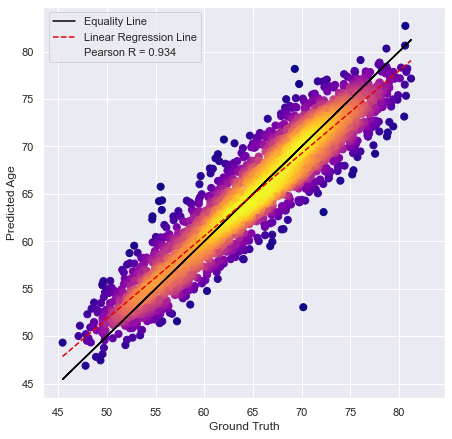

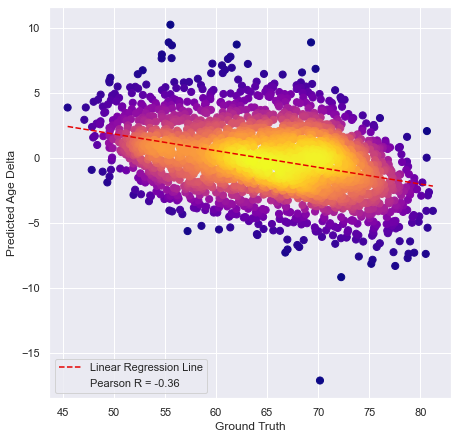

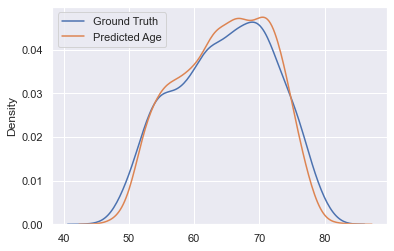

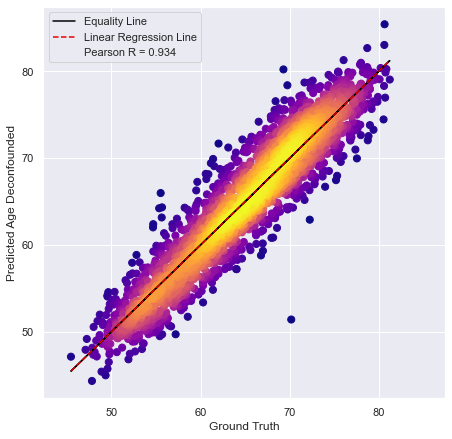

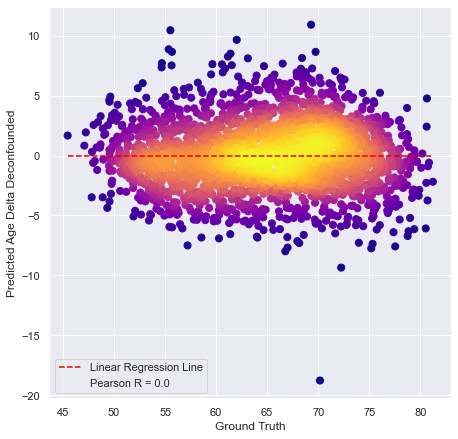

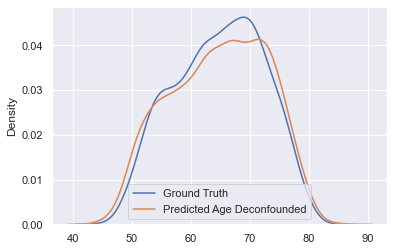

In [26]:
# reg, coefficients, intercept, mae_decon, pr_decon, Xtrain, Ytrain, Xtest, Ytest, Yhat_decon, Age_Deltas_decon = ElasticNet_wrap(
#     df_testA, df_testB, number_of_modalities=None, show_plots=True, verbose=True, deconfound=True)

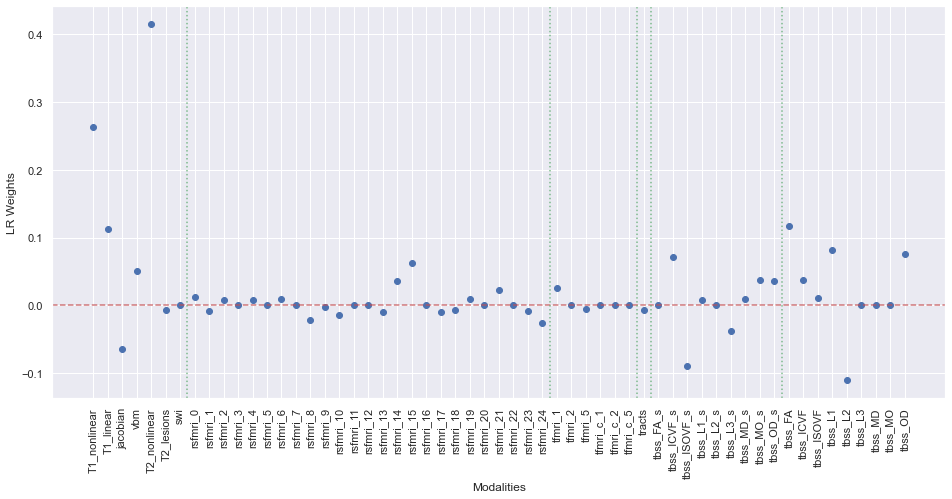

In [28]:
# plt.figure(figsize=(16, 7.2))
# # plt.plot(coefficients)
# plt.scatter(np.arange(0, Xtrain.shape[0]), coefficients)
# plt.xticks(np.arange(0, Xtrain.shape[0]), df.modality.to_list(), rotation=90);
# plt.xlabel("Modalities")
# plt.ylabel("LR Weights")
# plt.axhline(y=0, color='r', linestyle='--', alpha=0.75);
# plt.axvline(x=6.5, color='g', linestyle='dotted', alpha=0.75);
# plt.axvline(x=31.5, color='g', linestyle='dotted', alpha=0.75);
# plt.axvline(x=37.5, color='g', linestyle='dotted', alpha=0.75);
# plt.axvline(x=38.5, color='g', linestyle='dotted', alpha=0.75);
# plt.axvline(x=47.5, color='g', linestyle='dotted', alpha=0.75);

# Continue from before...

In [29]:
# os.remove(output_name)

## 1.1 Fitting a subclass of modalities, based on the observed performance from above

In [31]:
coef_df = pd.DataFrame.from_dict({
    'modalities' : df.modality.to_list(),
    'coefficients' : coefficients
})
coef_df['abs_coef'] = np.abs(coef_df.coefficients)
coef_df = coef_df.sort_values('abs_coef', ascending=False)
coef_df

,modalities,coefficients,abs_coef
4,T2_nonlinear,0.415254,0.415254
0,T1_nonlinear,0.263088,0.263088
48,tbss_FA,0.117200,0.117200
1,T1_linear,0.112380,0.112380
52,tbss_L2,-0.110288,0.110288
41,tbss_ISOVF_s,-0.089444,0.089444
51,tbss_L1,0.081236,0.081236
56,tbss_OD,0.076308,0.076308
40,tbss_ICVF_s,0.071081,0.071081
2,jacobian,-0.064894,0.064894


2.7230714635798012
MAE= 2.141269860039949
PR= 0.9331247457670092
MAE Decon= 2.2906057781154345
PR Decon= 0.9331247457670091


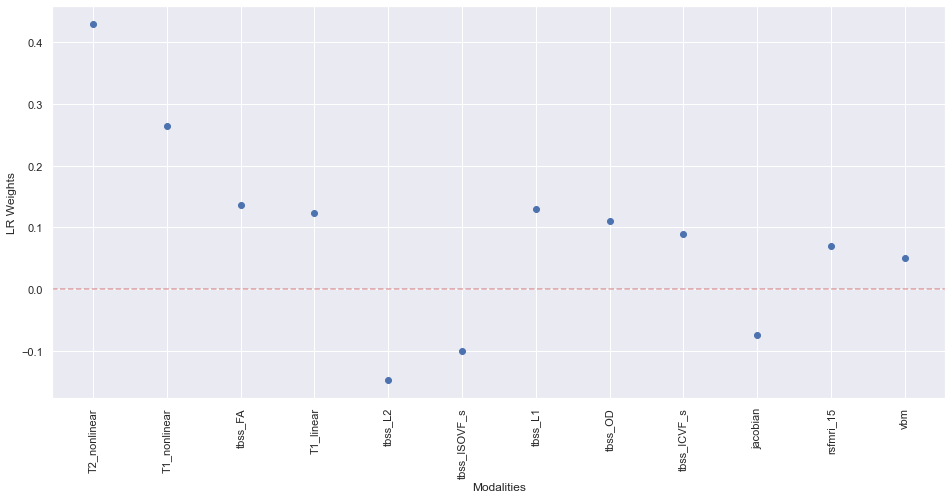

In [32]:
cutoff_weight = 0.04

misc_mod = coef_df[coef_df.abs_coef >= cutoff_weight].modalities.to_list()
x = LinearRegression_wrap(df_train=df_testA, df_test=df_testB, modalities=misc_mod, 
                              number_of_modalities=None, show_plots=False, verbose=True, deconfound=True)
plt.figure(figsize=(16, 7.2))
plt.scatter(np.arange(0, x[5].shape[0]), x[1])
plt.xticks(np.arange(0, x[5].shape[0]), misc_mod, rotation=90);
plt.xlabel("Modalities")
plt.ylabel("LR Weights")
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5);

## 1.2 Fitting Variables Progressivelly, in order of Beta-Weight-Coef value

In [33]:
ordered_modalities0 = coef_df.modalities.to_list()

maes_list0 = []
number_of_modalities0 = []

for i in range(2, len(coef_df)+1):
    modalities0 = ordered_modalities0[:i]
    x = LinearRegression_wrap(df_train=df_testA, df_test=df_testB, modalities=modalities0, 
                              number_of_modalities=None, show_plots=False, verbose=False, deconfound=True)
    mae = x[3]    
    maes_list0.append(mae)
    number_of_modalities0.append(i)

2.8138246014329007
2.7604587201771214
2.7515716260520966
2.75285132272502
2.7539146021138174
2.7409480968985753
2.7309770353540146
2.726713537133875
2.7215501481697206
2.72705955624831
2.7230714635798012
2.717894517133077
2.7122611468982214
2.7136388994563574
2.7167514108078645
2.710782856702519
2.7053641916248785
2.6988518034154003
2.6992843745331316
2.6995666397723874
2.7010278758977204
2.703137785237172
2.702979108263066
2.7027234275847443
2.7036220619918803
2.7015395043934225
2.7025108634468316
2.7030166607014086
2.7011600334157078
2.700763399979744
2.7009088573941376
2.6997574434546356
2.6995034220019325
2.6970099252507294
2.6993352147714575
2.6990707358889257
2.6993574778388747
2.69961480966012
2.699265351836123
2.6984010249847636
2.6982862481733245
2.6986572550225687
2.700423270996566
2.700540300666424
2.7005548898855767
2.7001177287493987
2.70030906034463
2.7006131926313177
2.7002142420891486
2.7000002969697574
2.700263011757031
2.700115233322463
2.699231839534003
2.69936980514

In [34]:
ordered_modalities0x = coef_df.modalities.to_list()

maes_list0x = []
number_of_modalities0x = []

for i in range(2, len(coef_df)+1):
    modalities0x = ordered_modalities0x[:i]
    x = LinearRegression_wrap(df_train=df_testA, df_test=df_testB, modalities=modalities0x, 
                              number_of_modalities=None, show_plots=False, verbose=False)
    maex = x[3]    
    maes_list0x.append(maex)
    number_of_modalities0x.append(i)

2.8138246014329007
2.7604587201771214
2.7515716260520966
2.75285132272502
2.7539146021138174
2.7409480968985753
2.7309770353540146
2.726713537133875
2.7215501481697206
2.72705955624831
2.7230714635798012
2.717894517133077
2.7122611468982214
2.7136388994563574
2.7167514108078645
2.710782856702519
2.7053641916248785
2.6988518034154003
2.6992843745331316
2.6995666397723874
2.7010278758977204
2.703137785237172
2.702979108263066
2.7027234275847443
2.7036220619918803
2.7015395043934225
2.7025108634468316
2.7030166607014086
2.7011600334157078
2.700763399979744
2.7009088573941376
2.6997574434546356
2.6995034220019325
2.6970099252507294
2.6993352147714575
2.6990707358889257
2.6993574778388747
2.69961480966012
2.699265351836123
2.6984010249847636
2.6982862481733245
2.6986572550225687
2.700423270996566
2.700540300666424
2.7005548898855767
2.7001177287493987
2.70030906034463
2.7006131926313177
2.7002142420891486
2.7000002969697574
2.700263011757031
2.700115233322463
2.699231839534003
2.69936980514

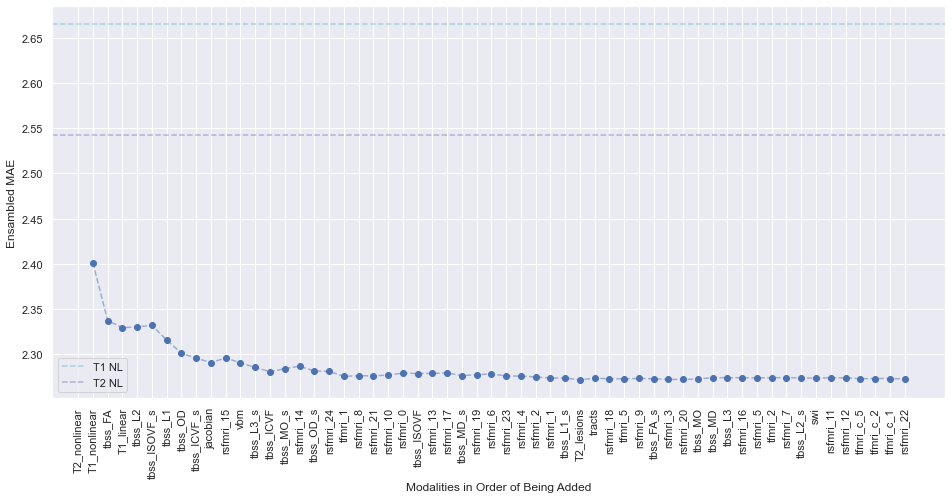

In [38]:
plt.figure(figsize=(16, 7.2))
plt.scatter(number_of_modalities0, maes_list0)
plt.plot(number_of_modalities0, maes_list0, 'b--', alpha=0.5)
plt.xticks(np.arange(1, Xtrain.shape[0]+1), ordered_modalities0, rotation=90);
plt.xlabel("Modalities in Order of Being Added")
plt.ylabel("Ensambled MAE")
plt.axhline(y=2.665, color='c', linestyle='--', alpha=0.5, label='T1 NL');
plt.axhline(y=2.542, color='m', linestyle='--', alpha=0.5, label='T2 NL');
plt.legend()

In [36]:
ordered_modalities0[np.argmin(maes_list0)]

'tbss_L1_s'

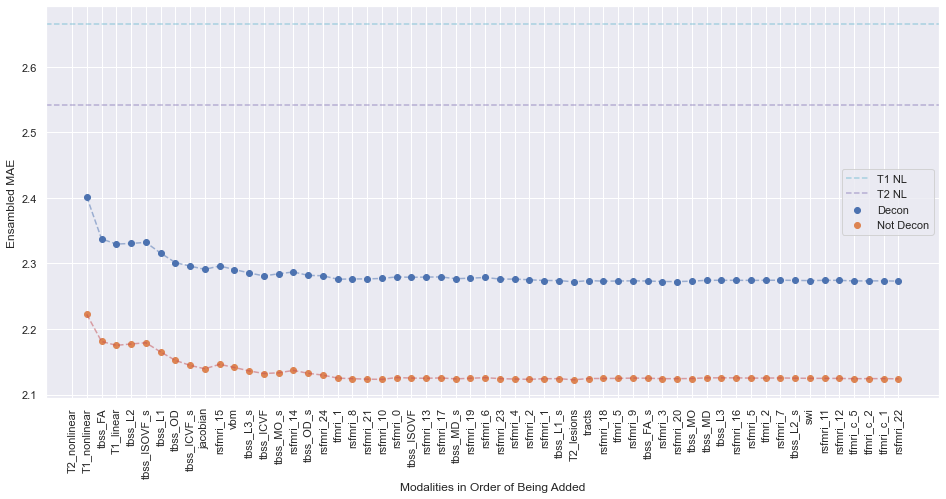

In [39]:
plt.figure(figsize=(16, 7.2))
plt.scatter(number_of_modalities0, maes_list0, label='Decon')
plt.plot(number_of_modalities0, maes_list0, 'b--', alpha=0.5)
plt.scatter(number_of_modalities0x, maes_list0x, label='Not Decon')
plt.plot(number_of_modalities0x, maes_list0x, 'r--', alpha=0.5)
plt.xticks(np.arange(1, Xtrain.shape[0]+1), ordered_modalities0, rotation=90);
plt.xlabel("Modalities in Order of Being Added")
plt.ylabel("Ensambled MAE")
plt.axhline(y=2.665, color='c', linestyle='--', alpha=0.5, label='T1 NL');
plt.axhline(y=2.542, color='m', linestyle='--', alpha=0.5, label='T2 NL');
plt.legend()

# 2. Fitting Variables Progressivelly, in order of best Test MAEs

In [40]:
modality_decon_maes = []

for idx in range(len(df)):
    modality_decon_mae = np.abs(df.iloc[idx].dataframe.age_delta_decon).mean()
    modality_decon_maes.append(modality_decon_mae)
    
mae_df = pd.DataFrame.from_dict({
    'modality': df.modality.to_list(),
    'mae_decon': modality_decon_maes
})

mae_df = mae_df.sort_values('mae_decon')
mae_df.head()

,modality,mae_decon
4,T2_nonlinear,2.541832
0,T1_nonlinear,2.665029
1,T1_linear,2.738320
49,tbss_ICVF,3.071851
3,vbm,3.116403


In [41]:
ordered_modalities = mae_df.modality.to_list()
maes_list = []
prs_list = []
number_of_modalities = []

for i in range(2, len(mae_df)+1):
    modalities = ordered_modalities[:i]
    x = LinearRegression_wrap(df_train=df_testA, df_test=df_testB, modalities=modalities, 
                              number_of_modalities=None, show_plots=False, verbose=False, deconfound=True)
    mae = x[3]
    pr = x[4]
    maes_list.append(mae)
    prs_list.append(pr)
    number_of_modalities.append(i)

2.8138246014329007
2.7893573160508165
2.756454760099434
2.751171723534335
2.733866571859239
2.729199544301041
2.729210099401947
2.729214286873189
2.7190473015097214
2.7208596410306103
2.7213487593372463
2.7207496288202733
2.720593394280159
2.7204617924675087
2.7183390095168063
2.717612354071754
2.7187557874558212
2.715912707670925
2.7089590564558454
2.711724736174546
2.7045089382551977
2.70491925663469
2.7108514250417226
2.7019162991645937
2.6994529613231832
2.698800980815165
2.698161675396371
2.6965455748027485
2.6965602027235924
2.6953943059639927
2.6928484840620075
2.6929965720929316
2.694056658289208
2.693857272229342
2.6942246031180432
2.699865133706124
2.6988488008541767
2.6988189163423653
2.699086872727377
2.699592619196653
2.6999229433593195
2.6991209424764526
2.698722690909913
2.700066336129328
2.6968217451728735
2.6973578358509918
2.695841397156822
2.694723262611062
2.695937396357299
2.6964683345158553
2.6967119910081134
2.6967472658104423
2.6985277239182226
2.698456189415683

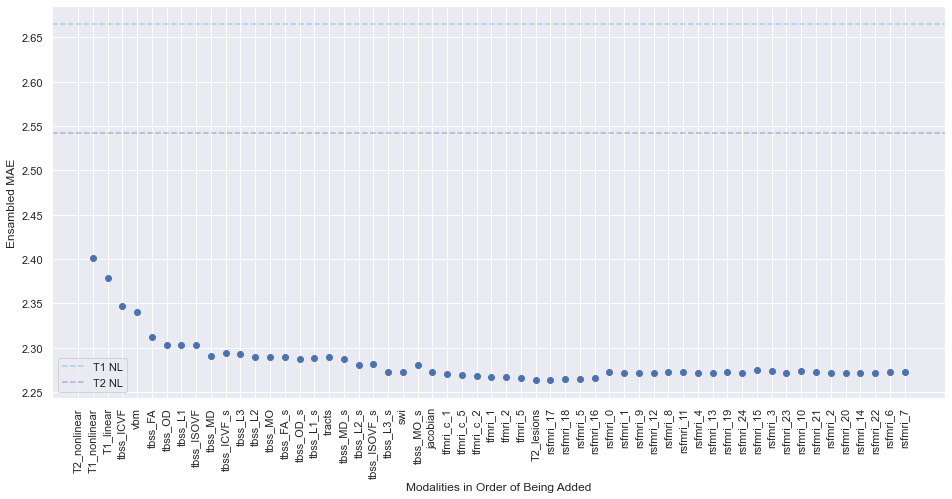

In [43]:
plt.figure(figsize=(16, 7.2))
plt.scatter(number_of_modalities, maes_list)
plt.xticks(np.arange(1, Xtrain.shape[0]+1), ordered_modalities, rotation=90);
plt.xlabel("Modalities in Order of Being Added")
plt.ylabel("Ensambled MAE")
plt.axhline(y=2.665, color='c', linestyle='--', alpha=0.5, label='T1 NL');
plt.axhline(y=2.542, color='m', linestyle='--', alpha=0.5, label='T2 NL');
plt.legend()

# 3. Fitting Variables Progressivelly, in order of best Train MAEs

In [45]:
# modality_decon_maest = []

# for idx in range(len(dft)):
#     modality_decon_maet = np.abs(dft.iloc[idx].dataframe.age_delta_decon).mean()
#     modality_decon_maest.append(modality_decon_maet)
    
# mae_dft = pd.DataFrame.from_dict({
#     'modality': dft.modality.to_list(),
#     'mae_decon': modality_decon_maest
# })

# mae_dft = mae_dft.sort_values('mae_decon')
# mae_dft.head()

In [46]:
# ordered_modalitiest = mae_dft.modality.to_list()
# maes_listt = []
# number_of_modalitiest = []

# for i in range(2, len(mae_df)+1):
#     modalities = ordered_modalitiest[:i]
#     x = LinearRegression_wrap(df_train=df_testA, df_test=df_testB, modalities=modalities, 
#                               number_of_modalities=None, show_plots=False, verbose=False, deconfound=True)
#     mae = x[3]
#     maes_listt.append(mae)
#     number_of_modalitiest.append(i)

In [47]:
# plt.figure(figsize=(16, 7.2))
# plt.scatter(number_of_modalitiest, maes_listt)
# plt.xticks(np.arange(1, Xtrain.shape[0]+1), ordered_modalitiest, rotation=90);
# plt.xlabel("Modalities in Order of Being Added")
# plt.ylabel("Ensambled MAE")
# plt.axhline(y=2.429, color='c', linestyle='--', alpha=0.5, label='T1 NL');
# plt.axhline(y=2.372, color='m', linestyle='--', alpha=0.5, label='T2 NL');
# plt.legend()

# 4. Fit Model to subgroups of variables (Notebook 4)

In [48]:
custom_modalities = ['T1_nonlinear', 'rsfmri_0', 'tfmri_1', 'tracts', 'tbss_FA']
custom_modalities_2 = ['T2_nonlinear', 'rsfmri_0', 'tfmri_1', 'tracts', 'tbss_ICVF']
custom_modalities_3 = ['T1_nonlinear', 'T2_nonlinear', 'swi', 'tracts', 'rsfmri_0', 'tfmri_1']

2.9181315728288792
MAE= 2.3114203941987777
PR= 0.9227352904981405
MAE Decon= 2.4926060820421267
PR Decon= 0.9227352904981405


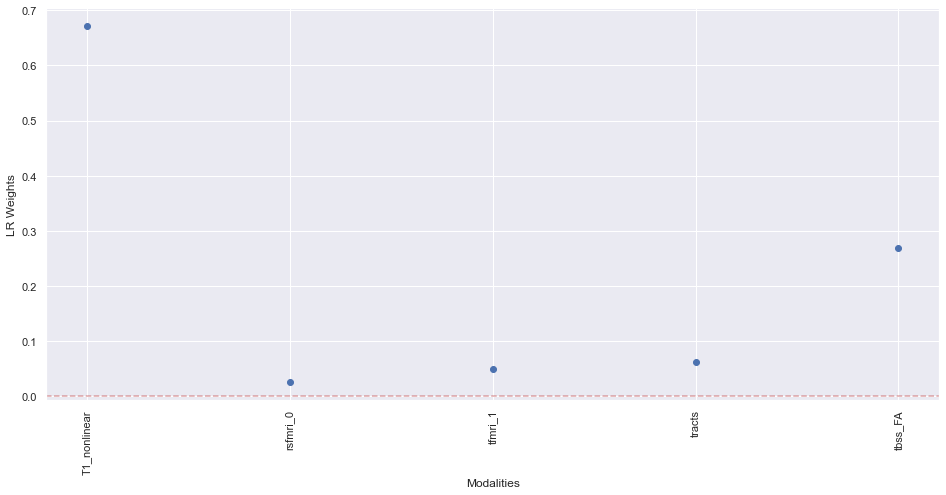

In [49]:
x = LinearRegression_wrap(df_train=df_testA, df_test=df_testB, modalities=custom_modalities, 
                              number_of_modalities=None, show_plots=False, verbose=True, deconfound=True)
plt.figure(figsize=(16, 7.2))
plt.scatter(np.arange(0, x[5].shape[0]), x[1])
plt.xticks(np.arange(0, x[5].shape[0]), custom_modalities, rotation=90);
plt.xlabel("Modalities")
plt.ylabel("LR Weights")
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5);

2.822273708439548
MAE= 2.2169433433094836
PR= 0.9279299429127591
MAE Decon= 2.4027015954737956
PR Decon= 0.9279299429127589


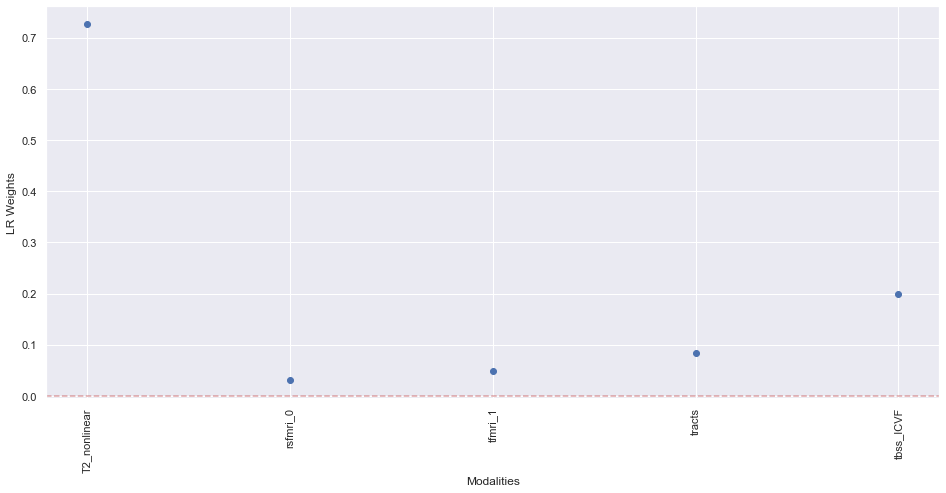

In [50]:
x = LinearRegression_wrap(df_train, df_test, modalities=custom_modalities_2, 
                              number_of_modalities=None, show_plots=False, verbose=True, deconfound=True)
plt.figure(figsize=(16, 7.2))
plt.scatter(np.arange(0, x[5].shape[0]), x[1])
plt.xticks(np.arange(0, x[5].shape[0]), custom_modalities_2, rotation=90);
plt.xlabel("Modalities")
plt.ylabel("LR Weights")
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5);

2.7825310869846596
MAE= 2.1979770496063957
PR= 0.9300261309904136
MAE Decon= 2.370710366645729
PR Decon= 0.9300261309904136


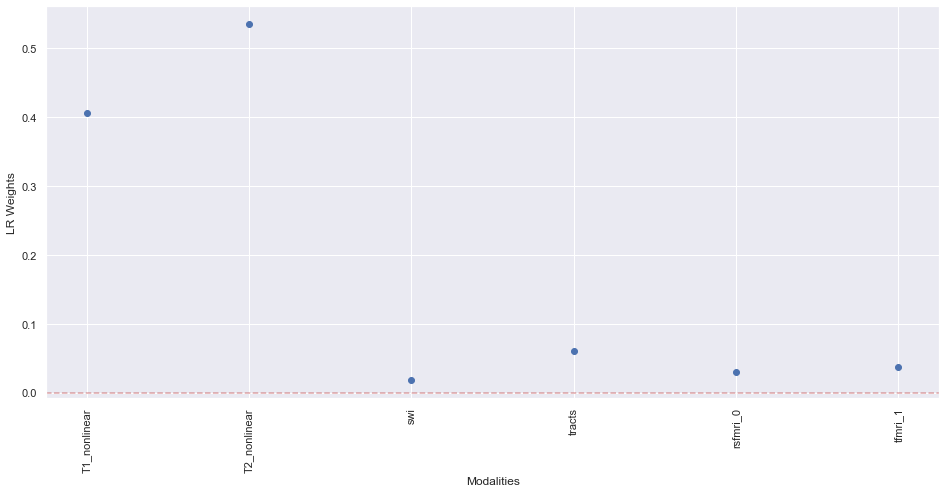

In [51]:
x = LinearRegression_wrap(df_train, df_test, modalities=custom_modalities_3, 
                              number_of_modalities=None, show_plots=False, verbose=True, deconfound=True)
plt.figure(figsize=(16, 7.2))
plt.scatter(np.arange(0, x[5].shape[0]), x[1])
plt.xticks(np.arange(0, x[5].shape[0]), custom_modalities_3, rotation=90);
plt.xlabel("Modalities")
plt.ylabel("LR Weights")
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5);

In [52]:
df_test.head()

,T1_nonlinear,T1_linear,jacobian,vbm,T2_nonlinear,T2_lesions,swi,rsfmri_0,rsfmri_1,rsfmri_2,...,tbss_FA,tbss_ICVF,tbss_ISOVF,tbss_L1,tbss_L2,tbss_L3,tbss_MD,tbss_MO,tbss_OD,target_age
1995,70.301960,71.880307,69.838718,73.728143,73.898550,72.442627,66.486627,64.960093,69.834643,62.343770,...,64.774132,72.619850,71.585567,73.181622,73.025147,74.976455,71.628845,69.588323,74.340763,77.611986
2682,65.544842,63.974553,62.261400,63.022292,67.380870,61.355960,65.141727,66.513993,69.161137,60.986258,...,63.446062,65.282101,65.646513,65.543627,66.599290,66.317293,65.595615,65.108424,65.091057,62.389384
1117,65.903570,65.495730,61.712228,65.155408,63.115961,64.414018,59.111989,61.315363,59.037748,60.713749,...,62.385809,64.182630,62.296586,66.467493,66.108393,66.276078,65.761343,63.206968,65.244336,66.140753
2651,69.497883,73.795662,68.981087,66.932085,68.470500,72.342867,67.238942,67.130893,71.601157,68.807543,...,70.124750,69.249878,70.717260,68.251463,71.317583,71.792955,70.097964,69.983847,69.884533,68.352169
2346,53.809285,57.470562,60.224921,56.306926,59.614605,57.104562,63.387025,57.299523,60.204006,62.027384,...,55.425612,56.049117,58.145698,59.213595,61.731932,62.031764,61.779696,58.838508,57.769367,50.348973


In [20]:
def combination_ensambling(df, df_train, df_test, custom_modalities=None, 
                           min_objects=None, max_objects=None, verbose=True):
       
    ensamble_names = []
    ensambled_dfs = []
    mae_improvements = []
    min_single_maes = []
    ensambled_maes = []
    
    if verbose:
        print("{:13} : {:6}  |  {:5} ".format('Modality', 'MAE', "PR"))
        print('-----------------------------------------------------------------------------------------------')
    
    
    modalities = df.modality.to_list()
    subjects = df.iloc[0].dataframe['Unnamed: 0'].to_list()
    
    if custom_modalities == None:
        custom_modalities = modalities
    
    objects = len(custom_modalities)
    
    if min_objects == None:
        min_objects = 2
    
    if max_objects == None:
        max_objects = objects+1
    else:
        max_objects = max_objects+1
    
    for sample in range(min_objects, max_objects):
        for subset in itertools.combinations(custom_modalities, sample):
            subset = list(subset)

            component_age_delta_decon_mean = []
            for modality in subset:
                component_age_delta_decon_mean.append(np.abs(df.iloc[modalities.index(modality)].dataframe.age_delta_decon).mean())

            x = LinearRegression_wrap(df_train, df_test, modalities=subset, 
                              number_of_modalities=None, show_plots=False, verbose=False, deconfound=True)
            
            mae = x[3]
            pr = x[4]

            if (mae < np.array(component_age_delta_decon_mean)).all():
                
                if verbose:
                    print(subset)
                
                name = ''
                
                for modality in subset:
                    if verbose:
                        print('{:13} :  {:.3f}  |  {:.3f}'.format(
                            modality, 
                            np.abs(df.iloc[modalities.index(modality)].dataframe.age_delta_decon).mean(),
                            pearsonr(df.iloc[modalities.index(modality)].dataframe.target_age, df.iloc[modalities.index(modality)].dataframe.output_age_decon)[0]))
                    if name == '':
                        name = modality
                    else:
                        name += ' '
                        name += modality
                if verbose:
                    print('{:13} :  {:.3f}  |  {:.3f}'.format(
                        'Ensamble', 
                        mae,
                        pr,
                    ))

                ensamble_names.append(name)
                
                mae_improvement = min(np.array(component_age_delta_decon_mean)) - mae
                mae_improvements.append(mae_improvement)
                
                min_single_mae = min(np.array(component_age_delta_decon_mean))
                min_single_maes.append(min_single_mae)

                ensambled_maes.append(mae)
                
                if verbose:
                    print('------------------------------------------------------------')
                
    ensamble_dct = {'modality': ensamble_names,
                    'min_single_mae': min_single_maes, 'ensambled_mae': ensambled_maes,
                    'mae_improvement': mae_improvements}
    ensamble_dct = pd.DataFrame.from_dict(ensamble_dct)
    
    return ensamble_dct

In [54]:
tmp_dct = combination_ensambling(df, df_train, df_test, custom_modalities=custom_modalities, 
                           min_objects=None, max_objects=None, verbose=True)

Modality      : MAE     |  PR    
-----------------------------------------------------------------------------------------------
3.093722602694942
3.033370610587699
['T1_nonlinear', 'tfmri_1']
T1_nonlinear  :  2.665  |  0.915
tfmri_1       :  4.675  |  0.792
Ensamble      :  2.612  |  0.916
------------------------------------------------------------
3.0081180473883498
['T1_nonlinear', 'tracts']
T1_nonlinear  :  2.665  |  0.915
tracts        :  3.821  |  0.845
Ensamble      :  2.594  |  0.918
------------------------------------------------------------
2.939993787213034
['T1_nonlinear', 'tbss_FA']
T1_nonlinear  :  2.665  |  0.915
tbss_FA       :  3.146  |  0.887
Ensamble      :  2.518  |  0.922
------------------------------------------------------------
4.521081175620118
['rsfmri_0', 'tfmri_1']
rsfmri_0      :  7.539  |  0.626
tfmri_1       :  4.675  |  0.792
Ensamble      :  4.491  |  0.802
------------------------------------------------------------
3.9904876190099867
['rsfmri_0', 

In [55]:
tmp_dct.sort_values('mae_improvement', ascending=False)

,modality,min_single_mae,ensambled_mae,mae_improvement
6,tfmri_1 tracts,3.821289,3.443800,0.377488
15,rsfmri_0 tfmri_1 tracts,3.821289,3.452110,0.369178
18,tfmri_1 tracts tbss_FA,3.146258,2.914688,0.231570
23,rsfmri_0 tfmri_1 tracts tbss_FA,3.146258,2.916571,0.229687
3,rsfmri_0 tfmri_1,4.674717,4.491359,0.183357
22,T1_nonlinear tfmri_1 tracts tbss_FA,2.665029,2.486917,0.178112
24,T1_nonlinear rsfmri_0 tfmri_1 tracts tbss_FA,2.665029,2.492606,0.172423
13,T1_nonlinear tfmri_1 tbss_FA,2.665029,2.497219,0.167810
14,T1_nonlinear tracts tbss_FA,2.665029,2.501016,0.164013
8,tracts tbss_FA,3.146258,2.982420,0.163838


In [56]:
tmp_dct.sort_values('ensambled_mae')

,modality,min_single_mae,ensambled_mae,mae_improvement
22,T1_nonlinear tfmri_1 tracts tbss_FA,2.665029,2.486917,0.178112
24,T1_nonlinear rsfmri_0 tfmri_1 tracts tbss_FA,2.665029,2.492606,0.172423
13,T1_nonlinear tfmri_1 tbss_FA,2.665029,2.497219,0.167810
14,T1_nonlinear tracts tbss_FA,2.665029,2.501016,0.164013
20,T1_nonlinear rsfmri_0 tfmri_1 tbss_FA,2.665029,2.503686,0.161343
21,T1_nonlinear rsfmri_0 tracts tbss_FA,2.665029,2.506755,0.158274
2,T1_nonlinear tbss_FA,2.665029,2.518372,0.146657
11,T1_nonlinear rsfmri_0 tbss_FA,2.665029,2.523716,0.141313
12,T1_nonlinear tfmri_1 tracts,2.665029,2.563567,0.101462
19,T1_nonlinear rsfmri_0 tfmri_1 tracts,2.665029,2.574966,0.090063


In [57]:
tmp_dct_2 = combination_ensambling(df, df_train, df_test, custom_modalities=custom_modalities_2, 
                           min_objects=None, max_objects=None, verbose=True)

Modality      : MAE     |  PR    
-----------------------------------------------------------------------------------------------
2.964411653204404
2.9068422822615454
['T2_nonlinear', 'tfmri_1']
T2_nonlinear  :  2.542  |  0.921
tfmri_1       :  4.675  |  0.792
Ensamble      :  2.501  |  0.923
------------------------------------------------------------
2.8948232021269824
['T2_nonlinear', 'tracts']
T2_nonlinear  :  2.542  |  0.921
tracts        :  3.821  |  0.845
Ensamble      :  2.486  |  0.924
------------------------------------------------------------
2.852128055545066
['T2_nonlinear', 'tbss_ICVF']
T2_nonlinear  :  2.542  |  0.921
tbss_ICVF     :  3.072  |  0.891
Ensamble      :  2.436  |  0.926
------------------------------------------------------------
4.521081175620118
['rsfmri_0', 'tfmri_1']
rsfmri_0      :  7.539  |  0.626
tfmri_1       :  4.675  |  0.792
Ensamble      :  4.491  |  0.802
------------------------------------------------------------
3.9904876190099867
['rsfmri_0

In [58]:
tmp_dct_2.sort_values('ensambled_mae')

,modality,min_single_mae,ensambled_mae,mae_improvement
22,T2_nonlinear tfmri_1 tracts tbss_ICVF,2.541832,2.395288,0.146544
24,T2_nonlinear rsfmri_0 tfmri_1 tracts tbss_ICVF,2.541832,2.402702,0.139130
14,T2_nonlinear tracts tbss_ICVF,2.541832,2.408412,0.133420
13,T2_nonlinear tfmri_1 tbss_ICVF,2.541832,2.415103,0.126729
21,T2_nonlinear rsfmri_0 tracts tbss_ICVF,2.541832,2.415426,0.126406
20,T2_nonlinear rsfmri_0 tfmri_1 tbss_ICVF,2.541832,2.424544,0.117288
2,T2_nonlinear tbss_ICVF,2.541832,2.435595,0.106237
11,T2_nonlinear rsfmri_0 tbss_ICVF,2.541832,2.443118,0.098714
12,T2_nonlinear tfmri_1 tracts,2.541832,2.457220,0.084612
19,T2_nonlinear rsfmri_0 tfmri_1 tracts,2.541832,2.464068,0.077764


In [59]:
tmp_dct_3 = combination_ensambling(df, df_train, df_test, custom_modalities=custom_modalities_3, 
                           min_objects=None, max_objects=None, verbose=True)

Modality      : MAE     |  PR    
-----------------------------------------------------------------------------------------------
2.8138246014329007
['T1_nonlinear', 'T2_nonlinear']
T1_nonlinear  :  2.665  |  0.915
T2_nonlinear  :  2.542  |  0.921
Ensamble      :  2.401  |  0.928
------------------------------------------------------------
3.0101210698610976
['T1_nonlinear', 'swi']
T1_nonlinear  :  2.665  |  0.915
swi           :  3.942  |  0.837
Ensamble      :  2.586  |  0.918
------------------------------------------------------------
3.0081180473883498
['T1_nonlinear', 'tracts']
T1_nonlinear  :  2.665  |  0.915
tracts        :  3.821  |  0.845
Ensamble      :  2.594  |  0.918
------------------------------------------------------------
3.093722602694942
3.033370610587699
['T1_nonlinear', 'tfmri_1']
T1_nonlinear  :  2.665  |  0.915
tfmri_1       :  4.675  |  0.792
Ensamble      :  2.612  |  0.916
------------------------------------------------------------
2.923640430002723
['T2_no

2.9554982759507973
['T1_nonlinear', 'swi', 'tracts', 'rsfmri_0', 'tfmri_1']
T1_nonlinear  :  2.665  |  0.915
swi           :  3.942  |  0.837
tracts        :  3.821  |  0.845
rsfmri_0      :  7.539  |  0.626
tfmri_1       :  4.675  |  0.792
Ensamble      :  2.533  |  0.921
------------------------------------------------------------
2.8637529750785293
['T2_nonlinear', 'swi', 'tracts', 'rsfmri_0', 'tfmri_1']
T2_nonlinear  :  2.542  |  0.921
swi           :  3.942  |  0.837
tracts        :  3.821  |  0.845
rsfmri_0      :  7.539  |  0.626
tfmri_1       :  4.675  |  0.792
Ensamble      :  2.452  |  0.926
------------------------------------------------------------
2.7825310869846596
['T1_nonlinear', 'T2_nonlinear', 'swi', 'tracts', 'rsfmri_0', 'tfmri_1']
T1_nonlinear  :  2.665  |  0.915
T2_nonlinear  :  2.542  |  0.921
swi           :  3.942  |  0.837
tracts        :  3.821  |  0.845
rsfmri_0      :  7.539  |  0.626
tfmri_1       :  4.675  |  0.792
Ensamble      :  2.371  |  0.930
-------

In [60]:
tmp_dct_3.sort_values('ensambled_mae')

,modality,min_single_mae,ensambled_mae,mae_improvement
49,T1_nonlinear T2_nonlinear swi tracts tfmri_1,2.541832,2.361013,0.180819
37,T1_nonlinear T2_nonlinear tracts tfmri_1,2.541832,2.365575,0.176257
33,T1_nonlinear T2_nonlinear swi tracts,2.541832,2.366554,0.175278
54,T1_nonlinear T2_nonlinear swi tracts rsfmri_0 ...,2.541832,2.370710,0.171121
14,T1_nonlinear T2_nonlinear tracts,2.541832,2.374122,0.167710
35,T1_nonlinear T2_nonlinear swi tfmri_1,2.541832,2.374296,0.167536
51,T1_nonlinear T2_nonlinear tracts rsfmri_0 tfmri_1,2.541832,2.375049,0.166783
48,T1_nonlinear T2_nonlinear swi tracts rsfmri_0,2.541832,2.377661,0.164171
16,T1_nonlinear T2_nonlinear tfmri_1,2.541832,2.382277,0.159555
36,T1_nonlinear T2_nonlinear tracts rsfmri_0,2.541832,2.385157,0.156675


## 4.1. Attempt at Multiple Combinations - with 2

In [21]:
modalities = df.modality.to_list()
corr_output_age_decons = []
corr_age_delta_decons = []
ensamble_names = []
min_maes = []
ensambled_maes = []

for subset in itertools.combinations(modalities, 2):
    subset = list(subset)
    ensamble_name = subset[0] + ' ' + subset[1]
    ensamble_names.append(ensamble_name)
    
    corr_output_age_decon = pearsonr(df.iloc[modalities.index(subset[0])].dataframe.output_age_decon, 
                                    df.iloc[modalities.index(subset[1])].dataframe.output_age_decon)[0]
    corr_output_age_decons.append(corr_output_age_decon)
    
    corr_age_delta_decon = pearsonr(df.iloc[modalities.index(subset[0])].dataframe.age_delta_decon, 
                                    df.iloc[modalities.index(subset[1])].dataframe.age_delta_decon)[0]
    corr_age_delta_decons.append(corr_age_delta_decon)
    
    min_mae = min(
                    np.abs(df.iloc[modalities.index(subset[0])].dataframe.age_delta_decon).mean(),
                    np.abs(df.iloc[modalities.index(subset[1])].dataframe.age_delta_decon).mean()
    )
    min_maes.append(min_mae)
           
    ensambled_mae = LinearRegression_wrap(df_train, df_test, modalities=subset, 
                              number_of_modalities=None, show_plots=False, verbose=False, deconfound=True)[3]
    ensambled_maes.append(ensambled_mae)
    
    
    
pr_df = pd.DataFrame.from_dict({
    'ensamble_name': ensamble_names,
    'corr_output_age_decon': corr_output_age_decons,
    'corr_age_delta_decon' : corr_age_delta_decons,
    'min_mae': min_maes,
    'ensambled_mae': ensambled_maes,
})

pr_df['mae_improvements'] = pr_df['min_mae'] - pr_df['ensambled_mae']



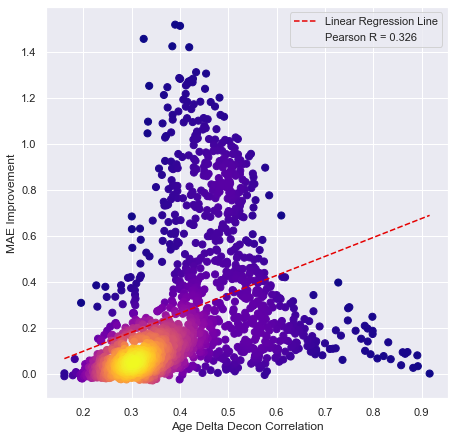

In [22]:
scatter_plot_heatmap(x=pr_df.corr_age_delta_decon, y=pr_df.mae_improvements, 
                     xlabel='Age Delta Decon Correlation', 
                   ylabel='MAE Improvement', title=None, set_scale=False, 
                   equality_line=False)

In [63]:
pr_df[pr_df.mae_improvements >= 0.8].sort_values('ensambled_mae')

,ensamble_name,corr_output_age_decon,corr_age_delta_decon,min_mae,ensambled_mae,mae_improvements
617,rsfmri_5 rsfmri_17,0.738763,0.547093,6.983365,6.027836,0.955529
1068,rsfmri_17 rsfmri_18,0.738623,0.543029,6.983365,6.039167,0.944198
618,rsfmri_5 rsfmri_18,0.754771,0.576490,6.994065,6.098613,0.895452
1035,rsfmri_16 rsfmri_17,0.719822,0.515370,6.983365,6.122995,0.860371
516,rsfmri_3 rsfmri_5,0.644322,0.428577,7.145245,6.152016,0.993230
...,...,...,...,...,...,...
472,rsfmri_2 rsfmri_7,0.544837,0.362741,8.492751,7.628900,0.863850
973,rsfmri_14 rsfmri_22,0.577142,0.384941,8.842425,7.717148,1.125276
699,rsfmri_7 rsfmri_14,0.592166,0.434638,8.842425,7.953612,0.888813
650,rsfmri_6 rsfmri_7,0.544125,0.374078,9.238483,7.993007,1.245476


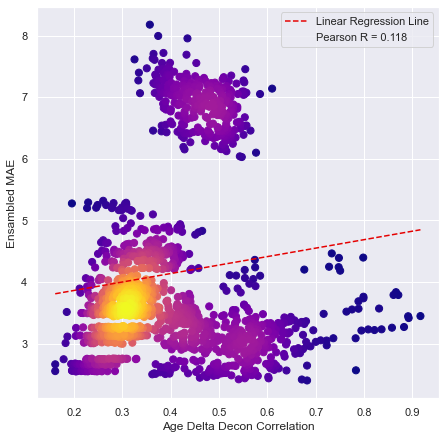

In [64]:
scatter_plot_heatmap(x=pr_df.corr_age_delta_decon, y=pr_df.ensambled_mae, 
                     xlabel='Age Delta Decon Correlation', 
                   ylabel='Ensambled MAE', title=None, set_scale=False, 
                   equality_line=False)

In [65]:
pr_df[(pr_df.ensambled_mae <= 2.3) & (pr_df.mae_improvements > 0)].sort_values('ensambled_mae')

,ensamble_name,corr_output_age_decon,corr_age_delta_decon,min_mae,ensambled_mae,mae_improvements


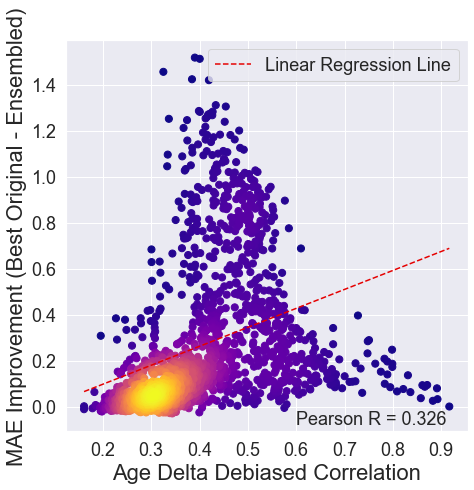

In [23]:
title_font_size=22
ticks_font_size=18
legend_font = 18
figsize=(7.2, 7.2)

x=pr_df.corr_age_delta_decon
y=pr_df.mae_improvements
xlabel='Age Delta Debiased Correlation'
ylabel='MAE Improvement (Best Original - Ensembled)'
title=None
set_scale=False 
equality_line=False


if isinstance(x, pd.Series):
    x = x.to_numpy()

if isinstance(y, pd.Series):
    y = y.to_numpy()

fig = plt.figure(figsize=figsize)

sns.set_style("darkgrid", {'image.cmap': u'plasma'})
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]
plt.scatter(x,y,c=z,s=50)
if equality_line == True:
    plt.plot(x, x, ls="-", color = sns.xkcd_rgb['black'], label='Equality Line') #this is just the line of equality

X_mat=np.vstack((np.ones(len(x)), x)).T
beta_hat = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(y)
b,w = beta_hat[0],beta_hat[1]
x2 = np.linspace(np.min(x),np.max(x),num=10)
y2 = w * x2 + b
plt.plot(x2,y2,ls='--', color= sns.xkcd_rgb['red'], label='Linear Regression Line')

pearson_correlation = pearsonr(x,y)[0]
text_x = 0.6
text_y = -0.075
lbl = 'Pearson R = '+str(round(pearson_correlation,3))
plt.text(text_x, text_y, lbl, fontsize=legend_font)

if set_scale == True:
    x_min, x_max = np.min(x), np.max(x)
    y_min, y_max = np.min(y), np.max(y)
    c_min, c_max = min(x_min, y_min), max(x_max, y_max)
    plt.xlim([c_min-2, c_max+2])
    plt.ylim([c_min-2, c_max+2])

plt.xlabel(xlabel, fontsize = title_font_size)
plt.ylabel(ylabel, fontsize = title_font_size)

plt.xticks(fontsize=ticks_font_size)
plt.yticks(fontsize=ticks_font_size)


# plt.plot([],[],' ',label=lbl)

plt.title(title, fontsize= title_font_size)
plt.legend(fontsize = legend_font)
plt.show()

fig.savefig('Male_linear_regression_ensembling_mae_improvement_vs_correlation.png', bbox_inches='tight', facecolor='white')



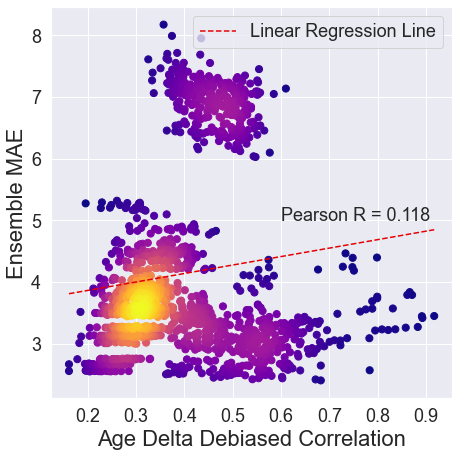

In [25]:
title_font_size=22
ticks_font_size=18
legend_font = 18
figsize=(7.2, 7.2)

x=pr_df.corr_age_delta_decon
y=pr_df.ensambled_mae
xlabel='Age Delta Debiased Correlation'
ylabel='Ensemble MAE'
title=None
set_scale=False 
equality_line=False


if isinstance(x, pd.Series):
    x = x.to_numpy()

if isinstance(y, pd.Series):
    y = y.to_numpy()

fig = plt.figure(figsize=figsize)

sns.set_style("darkgrid", {'image.cmap': u'plasma'})
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]
plt.scatter(x,y,c=z,s=50)
if equality_line == True:
    plt.plot(x, x, ls="-", color = sns.xkcd_rgb['black'], label='Equality Line') #this is just the line of equality

X_mat=np.vstack((np.ones(len(x)), x)).T
beta_hat = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(y)
b,w = beta_hat[0],beta_hat[1]
x2 = np.linspace(np.min(x),np.max(x),num=10)
y2 = w * x2 + b
plt.plot(x2,y2,ls='--', color= sns.xkcd_rgb['red'], label='Linear Regression Line')

pearson_correlation = pearsonr(x,y)[0]
text_x = 0.6
text_y = 5
lbl = 'Pearson R = '+str(round(pearson_correlation,3))
plt.text(text_x, text_y, lbl, fontsize=legend_font)

if set_scale == True:
    x_min, x_max = np.min(x), np.max(x)
    y_min, y_max = np.min(y), np.max(y)
    c_min, c_max = min(x_min, y_min), max(x_max, y_max)
    plt.xlim([c_min-2, c_max+2])
    plt.ylim([c_min-2, c_max+2])

plt.xlabel(xlabel, fontsize = title_font_size)
plt.ylabel(ylabel, fontsize = title_font_size)

plt.xticks(fontsize=ticks_font_size)
plt.yticks(fontsize=ticks_font_size)


# plt.plot([],[],' ',label=lbl)

plt.title(title, fontsize= title_font_size)
plt.legend(fontsize = legend_font, loc='upper right')
plt.show()

fig.savefig('Male_linear_regression_ensembling_ensemble_mae_vs_correlation.png', bbox_inches='tight', facecolor='white')


## Attempt at Multiple Combinations with 3

In [67]:
modalities = df.modality.to_list()
ensamble_names = []
min_maes = []
ensambled_maes = []

for subset in itertools.combinations(modalities, 3):
    subset = list(subset)
    ensamble_name = subset[0] + ' ' + subset[1] + ' ' + subset[2]
    ensamble_names.append(ensamble_name)
    
    min_mae = min(
                    np.abs(df.iloc[modalities.index(subset[0])].dataframe.age_delta_decon).mean(),
                    np.abs(df.iloc[modalities.index(subset[1])].dataframe.age_delta_decon).mean(),
                    np.abs(df.iloc[modalities.index(subset[2])].dataframe.age_delta_decon).mean()
    )
    min_maes.append(min_mae)
           
    ensambled_mae = LinearRegression_wrap(df_train, df_test, modalities=subset, 
                              number_of_modalities=None, show_plots=False, verbose=False, deconfound=True)[3]
    ensambled_maes.append(ensambled_mae)
    
    
    
pr_df2 = pd.DataFrame.from_dict({
    'ensamble_name': ensamble_names,
    'min_mae': min_maes,
    'ensambled_mae': ensambled_maes,
})

pr_df2['mae_improvements'] = pr_df2['min_mae'] - pr_df2['ensambled_mae']

In [68]:
pr_df2

,ensamble_name,min_mae,ensambled_mae,mae_improvements
0,T1_nonlinear T1_linear jacobian,2.665029,2.563441,0.101588
1,T1_nonlinear T1_linear vbm,2.665029,2.513682,0.151347
2,T1_nonlinear T1_linear T2_nonlinear,2.541832,2.379079,0.162752
3,T1_nonlinear T1_linear T2_lesions,2.665029,2.562785,0.102244
4,T1_nonlinear T1_linear swi,2.665029,2.517622,0.147407
...,...,...,...,...
29255,tbss_L2 tbss_MO tbss_OD,3.159359,2.937969,0.221390
29256,tbss_L3 tbss_MD tbss_MO,3.446519,3.098889,0.347630
29257,tbss_L3 tbss_MD tbss_OD,3.159359,3.033744,0.125615
29258,tbss_L3 tbss_MO tbss_OD,3.159359,2.925519,0.233840


In [69]:
pr_df2.sort_values('mae_improvements', ascending=False)

,ensamble_name,min_mae,ensambled_mae,mae_improvements
13309,rsfmri_3 rsfmri_10 rsfmri_20,8.315296,6.352508,1.962788
11970,rsfmri_2 rsfmri_3 rsfmri_10,8.315296,6.417340,1.897956
11980,rsfmri_2 rsfmri_3 rsfmri_20,8.315296,6.456977,1.858318
13645,rsfmri_3 rsfmri_20 rsfmri_21,8.315296,6.467469,1.847826
13310,rsfmri_3 rsfmri_10 rsfmri_21,8.315296,6.472003,1.843292
...,...,...,...,...
5857,T2_nonlinear T2_lesions rsfmri_22,2.541832,2.567325,-0.025493
9972,rsfmri_0 rsfmri_7 tbss_MD,3.446519,3.472247,-0.025728
5841,T2_nonlinear T2_lesions rsfmri_6,2.541832,2.567660,-0.025828
21682,rsfmri_13 rsfmri_19 tbss_MD,3.446519,3.472400,-0.025881


In [70]:
print(len(pr_df2))
pr_df2[(pr_df2.ensambled_mae <= 2.275) & (pr_df2.mae_improvements > 0)].sort_values('ensambled_mae')

29260


,ensamble_name,min_mae,ensambled_mae,mae_improvements


# 5. Fit Model to highly correlated groups (Notebook 4)

In [73]:
smri_mod = modalities[:7]
rsfmri_mod = modalities[7:32]
tfmri_mod = modalities[32:38]
dmri_mod = modalities[38:]
tbss_s_mod = dmri_mod[1:10]
tbss_mod = dmri_mod[10:]

rsfmri_jac_mod = rsfmri_mod + ['jacobian']
tfmri_jac_mod = tfmri_mod + ['jacobian']

fmri_mod = rsfmri_mod + tfmri_mod
fmri_jac_mod = rsfmri_mod + tfmri_mod + ['jacobian']

tbss_s_mod_tracts = dmri_mod[1:10] + ['tracts']
tbss_mod_tract = dmri_mod[10:] + ['tracts']

mod_list = [smri_mod, rsfmri_mod, tfmri_mod, dmri_mod, tbss_s_mod, tbss_mod, rsfmri_jac_mod, tfmri_jac_mod, 
             fmri_mod, fmri_jac_mod, tbss_s_mod_tracts, tbss_mod_tract]
mod_names = ['smri_mod', 'rsfmri_mod', 'tfmri_mod', 'dmri_mod', 'tbss_s_mod', 'tbss_mod', 'rsfmri_jac_mod', 
             'tfmri_jac_mod', 'fmri_mod', 'fmri_jac_mod', 'tbss_s_mod_tracts', 'tbss_mod_tract']

modality_decon_maes = []

for idx in range(len(df)):
    modality_decon_mae = np.abs(df.iloc[idx].dataframe.age_delta_decon).mean()
    modality_decon_maes.append(modality_decon_mae)
    
mae_df = pd.DataFrame.from_dict({
    'modality': df.modality.to_list(),
    'mae_decon': modality_decon_maes
})

mae_df = mae_df.sort_values('mae_decon')
mae_df.head()

def ensamble_sub_modality_groups(sub_modality_group, mae_df, df, df_train, df_test, sub_modality_name):

    ordered_modalities = mae_df.modality.to_list()
    ordered_modalities = [modality for modality in ordered_modalities if modality in sub_modality_group]
    print(ordered_modalities)

    maes_list = []
    number_of_modalitiest = []

    for i in range(2, len(ordered_modalities)+1):
        modalities = ordered_modalities[:i]
        x = LinearRegression_wrap(df_train, df_test, modalities=modalities, 
                              number_of_modalities=None, show_plots=False, verbose=False, deconfound=True)
                
        ensambled_mae = x[3]
        maes_list.append(ensambled_mae)
        number_of_modalitiest.append(i)
        
    plt.figure(figsize=(12.8, 4.8))
    plt.subplot(121)
    plt.plot(maes_list)
    plt.title(sub_modality_name)
    plt.plot([],[],' ',label='MIN MAE=' + str(min(maes_list)))
    plt.plot([],[],' ',label='MIN LOC=' + str(1 + np.argmin(np.array(maes_list))))
    plt.legend()
    plt.xlabel('No of Modalitities Ensambled with MAE Rank')
    plt.ylabel('Ensambled MAE')
    plt.show()
    
    print('-------')


['T2_nonlinear', 'T1_nonlinear', 'T1_linear', 'vbm', 'swi', 'jacobian', 'T2_lesions']


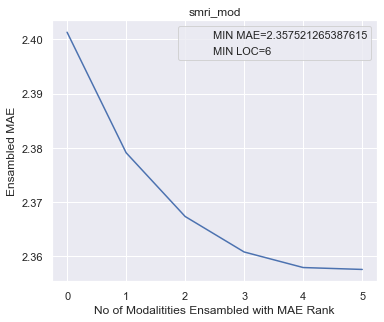

-------
['rsfmri_17', 'rsfmri_18', 'rsfmri_5', 'rsfmri_16', 'rsfmri_0', 'rsfmri_1', 'rsfmri_9', 'rsfmri_12', 'rsfmri_8', 'rsfmri_11', 'rsfmri_4', 'rsfmri_13', 'rsfmri_19', 'rsfmri_24', 'rsfmri_15', 'rsfmri_3', 'rsfmri_23', 'rsfmri_10', 'rsfmri_21', 'rsfmri_2', 'rsfmri_20', 'rsfmri_14', 'rsfmri_22', 'rsfmri_6', 'rsfmri_7']


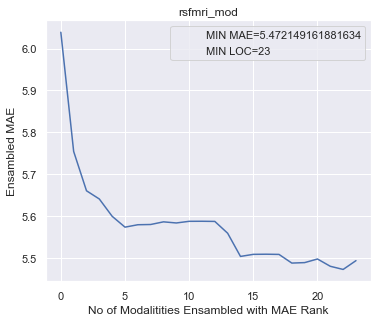

-------
['tfmri_c_1', 'tfmri_c_5', 'tfmri_c_2', 'tfmri_1', 'tfmri_2', 'tfmri_5']


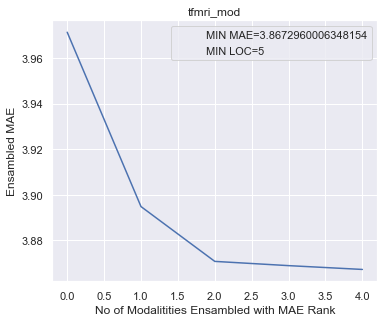

-------
['tbss_ICVF', 'tbss_FA', 'tbss_OD', 'tbss_L1', 'tbss_ISOVF', 'tbss_MD', 'tbss_ICVF_s', 'tbss_L3', 'tbss_L2', 'tbss_MO', 'tbss_FA_s', 'tbss_OD_s', 'tbss_L1_s', 'tracts', 'tbss_MD_s', 'tbss_L2_s', 'tbss_ISOVF_s', 'tbss_L3_s', 'tbss_MO_s']


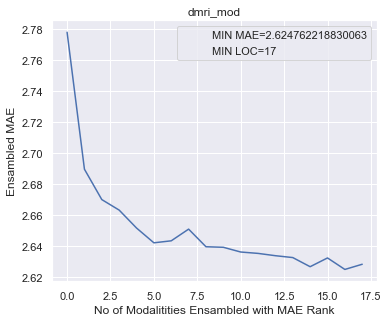

-------
['tbss_ICVF_s', 'tbss_FA_s', 'tbss_OD_s', 'tbss_L1_s', 'tbss_MD_s', 'tbss_L2_s', 'tbss_ISOVF_s', 'tbss_L3_s', 'tbss_MO_s']


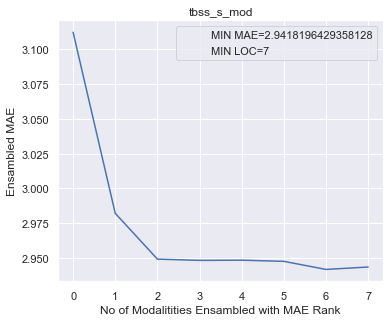

-------
['tbss_ICVF', 'tbss_FA', 'tbss_OD', 'tbss_L1', 'tbss_ISOVF', 'tbss_MD', 'tbss_L3', 'tbss_L2', 'tbss_MO']


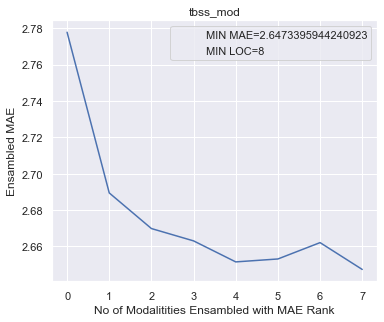

-------
['jacobian', 'rsfmri_17', 'rsfmri_18', 'rsfmri_5', 'rsfmri_16', 'rsfmri_0', 'rsfmri_1', 'rsfmri_9', 'rsfmri_12', 'rsfmri_8', 'rsfmri_11', 'rsfmri_4', 'rsfmri_13', 'rsfmri_19', 'rsfmri_24', 'rsfmri_15', 'rsfmri_3', 'rsfmri_23', 'rsfmri_10', 'rsfmri_21', 'rsfmri_2', 'rsfmri_20', 'rsfmri_14', 'rsfmri_22', 'rsfmri_6', 'rsfmri_7']


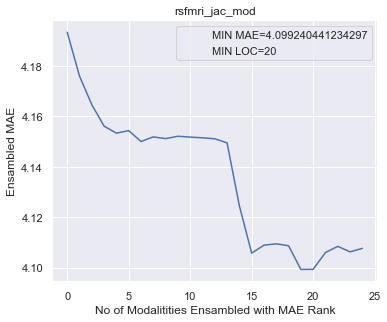

-------
['jacobian', 'tfmri_c_1', 'tfmri_c_5', 'tfmri_c_2', 'tfmri_1', 'tfmri_2', 'tfmri_5']


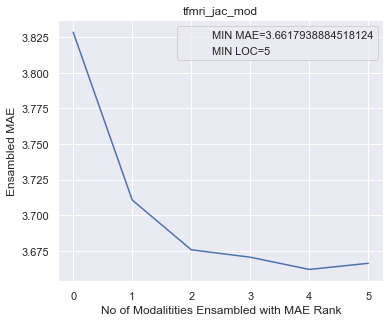

-------
['tfmri_c_1', 'tfmri_c_5', 'tfmri_c_2', 'tfmri_1', 'tfmri_2', 'tfmri_5', 'rsfmri_17', 'rsfmri_18', 'rsfmri_5', 'rsfmri_16', 'rsfmri_0', 'rsfmri_1', 'rsfmri_9', 'rsfmri_12', 'rsfmri_8', 'rsfmri_11', 'rsfmri_4', 'rsfmri_13', 'rsfmri_19', 'rsfmri_24', 'rsfmri_15', 'rsfmri_3', 'rsfmri_23', 'rsfmri_10', 'rsfmri_21', 'rsfmri_2', 'rsfmri_20', 'rsfmri_14', 'rsfmri_22', 'rsfmri_6', 'rsfmri_7']


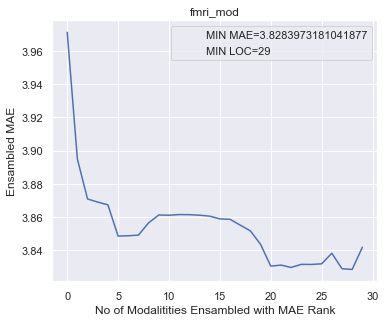

-------
['jacobian', 'tfmri_c_1', 'tfmri_c_5', 'tfmri_c_2', 'tfmri_1', 'tfmri_2', 'tfmri_5', 'rsfmri_17', 'rsfmri_18', 'rsfmri_5', 'rsfmri_16', 'rsfmri_0', 'rsfmri_1', 'rsfmri_9', 'rsfmri_12', 'rsfmri_8', 'rsfmri_11', 'rsfmri_4', 'rsfmri_13', 'rsfmri_19', 'rsfmri_24', 'rsfmri_15', 'rsfmri_3', 'rsfmri_23', 'rsfmri_10', 'rsfmri_21', 'rsfmri_2', 'rsfmri_20', 'rsfmri_14', 'rsfmri_22', 'rsfmri_6', 'rsfmri_7']


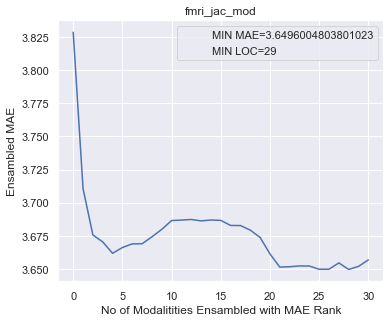

-------
['tbss_ICVF_s', 'tbss_FA_s', 'tbss_OD_s', 'tbss_L1_s', 'tracts', 'tbss_MD_s', 'tbss_L2_s', 'tbss_ISOVF_s', 'tbss_L3_s', 'tbss_MO_s']


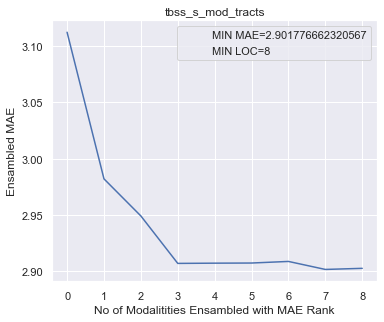

-------
['tbss_ICVF', 'tbss_FA', 'tbss_OD', 'tbss_L1', 'tbss_ISOVF', 'tbss_MD', 'tbss_L3', 'tbss_L2', 'tbss_MO', 'tracts']


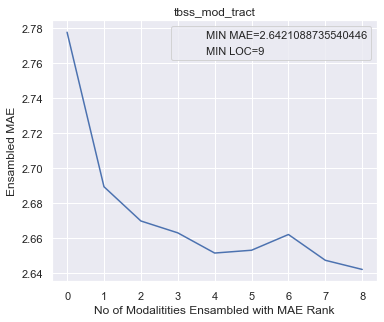

-------


In [74]:
for idx, sub_mod in enumerate(mod_list):
    ensamble_sub_modality_groups(sub_modality_group=sub_mod, mae_df=mae_df, 
                                 df=df, df_train=df_train, df_test=df_test,
                                 sub_modality_name=mod_names[idx])


In [75]:
x = tmp_dct = combination_ensambling(df, df_train, df_test, custom_modalities=smri_mod, 
                           min_objects=None, max_objects=None, verbose=False)
x.sort_values('mae_improvement', ascending=False).head()

,modality,min_single_mae,ensambled_mae,mae_improvement
46,jacobian T2_lesions swi,3.942241,3.399488,0.542753
11,jacobian swi,3.942241,3.464070,0.478172
10,jacobian T2_lesions,4.287973,3.982578,0.305395
16,T2_lesions swi,3.942241,3.683427,0.258814
44,jacobian vbm swi,3.116403,2.877767,0.238637


In [76]:
x = tmp_dct = combination_ensambling(df, df_train, df_test, custom_modalities=tfmri_mod, 
                           min_objects=None, max_objects=None, verbose=False)
x.sort_values('mae_improvement', ascending=False).head()

,modality,min_single_mae,ensambled_mae,mae_improvement
52,tfmri_1 tfmri_2 tfmri_5 tfmri_c_2 tfmri_c_5,4.62837,3.931199,0.697171
43,tfmri_1 tfmri_5 tfmri_c_2 tfmri_c_5,4.62837,3.934645,0.693724
40,tfmri_1 tfmri_2 tfmri_c_2 tfmri_c_5,4.62837,3.939123,0.689247
24,tfmri_1 tfmri_c_2 tfmri_c_5,4.62837,3.944111,0.684258
37,tfmri_1 tfmri_2 tfmri_5 tfmri_c_5,4.62837,3.984491,0.643879


MAE= 4.239588366688851
PR= 0.7220219746001237
MAE Decon= 5.748582077460319
PR Decon= 0.7220219746001237


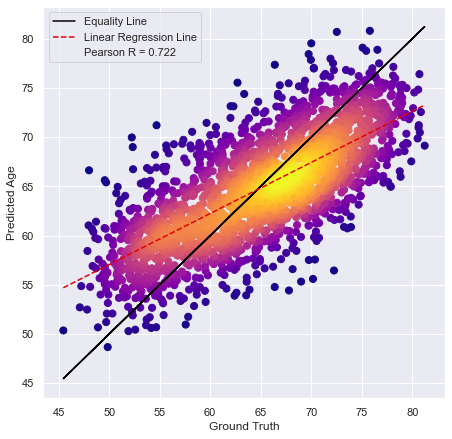

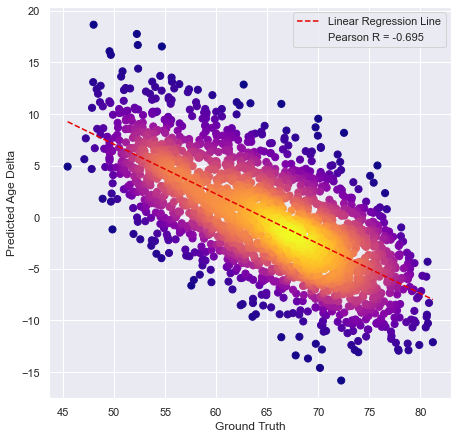

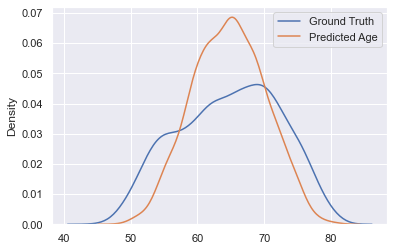

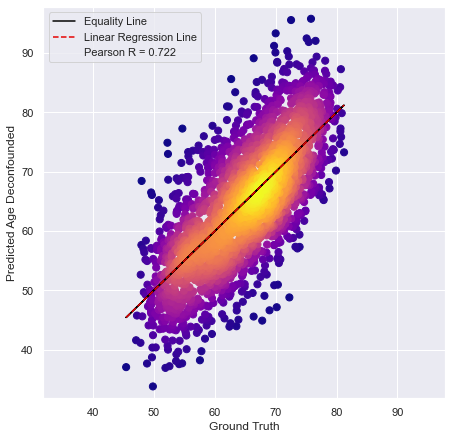

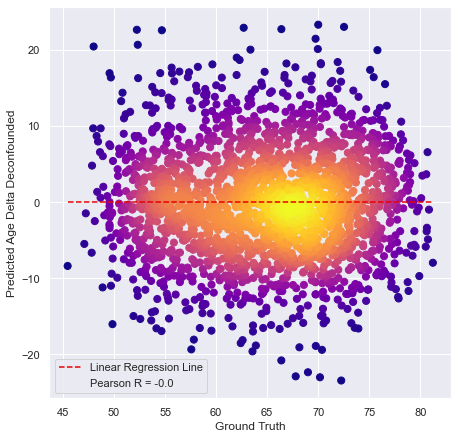

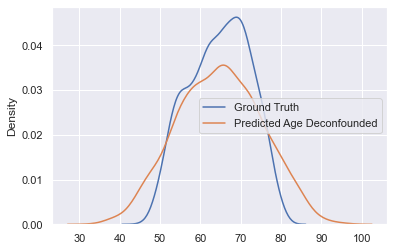

In [77]:
tmp_mod= ['rsfmri_0', 'rsfmri_22', 'rsfmri_11', 'rsfmri_17', 'rsfmri_18']
# tmp_mod = ['rsfmri_0', 'rsfmri_22', 'rsfmri_11']
_ = LinearRegression_wrap(df_train, df_test, modalities = tmp_mod, 
                      number_of_modalities=None, show_plots=True, verbose=True, deconfound=True)

['rsfmri_17', 'rsfmri_18', 'rsfmri_5', 'rsfmri_16', 'rsfmri_0', 'rsfmri_1', 'rsfmri_9', 'rsfmri_12', 'rsfmri_8', 'rsfmri_11', 'rsfmri_4', 'rsfmri_13', 'rsfmri_19', 'rsfmri_24', 'rsfmri_15', 'rsfmri_3', 'rsfmri_23', 'rsfmri_10', 'rsfmri_21', 'rsfmri_2', 'rsfmri_20', 'rsfmri_14', 'rsfmri_22', 'rsfmri_6', 'rsfmri_7']


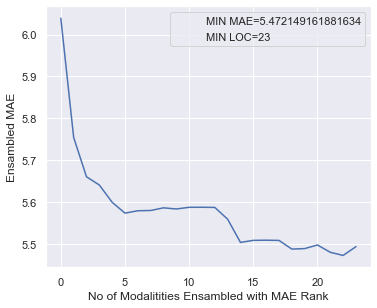

-------


In [78]:
ensamble_sub_modality_groups(sub_modality_group=rsfmri_mod, mae_df=mae_df, 
                                 df=df, df_train=df_train, df_test=df_test,
                                 sub_modality_name=None)

In [79]:
_ = LinearRegression_wrap(df_train, df_test, modalities = tmp_mod, 
                      number_of_modalities=None, show_plots=False, verbose=True)

MAE= 4.239588366688851
PR= 0.7220219746001237
